# Breast cancer results

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from utilities_namespace import *
from functools import partial

In [2]:
%%capture
%load_ext rpy2.ipython
%R require(ggplot2)

In [3]:
%%R
source('../../helpers/plots/utilities.R')
source('../../thirdparty/reverselog_trans.R')

In [4]:
from helpers.notebooks import notebooks_importer

In [5]:
import warnings
warnings.filterwarnings('ignore', message='.*Converting pandas "Category" series to R factor is only possible when categories are strings.*')
warnings.filterwarnings('ignore', message='.*notch went outside hinges.*')

## Data munging and benchmark setup

### Scoring functions

An overview of different scoring functions is outlined in the "Methods" notebook.

A concise list of all metrics used for benchmarking (with parameters) is available in "Benchmarking setup" notebook.

In [6]:
%%capture
from Benchmarking_setup import (
    tested_scoring_functions,
    tested_single_sample_functions,
    tested_multi_sample_functions,
    # diregarded as being way too slow, but their benchmark with timings belongs here
    single_sample_gene_set_based,
    # it is always good to know if the results are better than by chance
    ss_random_normal_score,    # single sample version 
    ms_random_normal_score     # multi sample version
)

In [7]:
assert tested_scoring_functions == (
    tested_single_sample_functions + tested_multi_sample_functions
)

In [8]:
[func.__name__ for func in tested_scoring_functions]

['score_spearman',
 'x_sum',
 'x_product',
 'x_cos',
 'connectivity_score_signature_kolmogorov_smirnov_conditional_difference',
 'connectivity_score_signature_kolmogorov_smirnov_difference',
 'connectivity_score_signature_cramér_von_mises_difference',
 'pharmaco_gx_connectivity_score',
 'plage_None_mx_diff:True',
 'gsva_None_mx_diff:True',
 'ssgsea_None_mx_diff:True',
 'zscore_None_mx_diff:True',
 'roast_score',
 'cudaGSEA_1000_c2.cp.kegg_mean_0.5_fill_0_True_phenotype_twopass_signal2noise',
 'cudaGSEA_1000_c2.cp.reactome_mean_0.5_fill_0_True_phenotype_twopass_signal2noise',
 'cudaGSEA_1000_h.all_mean_0.5_fill_0_True_phenotype_twopass_signal2noise']

In [9]:
show_source(tested_scoring_functions[5])

### Data for Drug-BRCA associations

In [10]:
%%capture
import Breast_cancer_data as data_brca

### Tested substances

In [11]:
from data_sources.drug_connectivity_map import DrugConnectivityMap
dcm = DrugConnectivityMap()

In [12]:
queried_signatures = set(data_brca.indications_singatures) | set(data_brca.contraindications_singatures)

In [13]:
queried_substances = dcm.identify_substances(queried_signatures)

In [14]:
all_other_signatures = dcm.all_signatures_except(queried_substances)

In [15]:
all_other_substances = dcm.identify_substances(all_other_signatures)

In [16]:
len(all_other_signatures), len(all_other_substances)

(470593, 28872)

Note: testing all the signatures would not be feasible as:

In [17]:
feasibility_subset_signatures = len(queried_signatures)
x_time_more_needed = len(all_other_signatures) / feasibility_subset_signatures

# timings in the feasibility subset:
fastest_function = 20 # seconds

fastest_function * x_time_more_needed / 60 / 60 # hours

2.703625186717224

and that would be a single repeat of the fastest function - now way to systematically apply this with 1000s of permutations

In [18]:
len(data_brca.all_control_signatures.columns), len(dcm.identify_substances(data_brca.all_control_signatures))

(157, 11)

#### Selection of substances and signatures for tests:

Only exemplar compounds with at least 7 signatures were selected:

In [19]:
all_selected_compounds = (
    dcm.sig_metrics[dcm.sig_metrics.is_exemplar == 1]
    .query('pert_type == "trt_cp"')
    .groupby('pert_iname')
    .filter(lambda signatures: len(signatures) >= 7)
)

Which means testing:

In [20]:
len(set(all_selected_compounds.pert_iname)) / len(all_other_substances) * 100

18.93183707398171

percent of all available substances.

Or 15.5% of signatures:

In [21]:
len(all_selected_compounds) / len(all_other_signatures) * 100

15.48769318710648

In [22]:
len(all_selected_compounds)

72884

In [23]:
len(set(all_selected_compounds.pert_iname))

5466

In [24]:
other_compounds = all_selected_compounds[
    ~all_selected_compounds.pert_iname.isin(queried_substances)
]

In [25]:
%%time
all_other_selected = dcm.from_ids(other_compounds.sig_id)

CPU times: user 2min 38s, sys: 7.91 s, total: 2min 46s
Wall time: 4min 7s


In [26]:
all_other_selected

,CPC004_A375_6H:BRD-K20482099-001-01-1:10,CPC004_A375_6H:BRD-K03670461-001-02-0:10,CPC004_A375_6H:BRD-K36737713-001-01-6:10,CPC004_A375_6H:BRD-A14966924-001-03-0:10,CPC004_A375_6H:BRD-K30020243-051-01-7:10,...,PCLB003_PC3_24H:BRD-K75295174-001-01-9:10,PCLB003_PC3_24H:BRD-K67174588-048-03-3:10,PCLB003_PC3_24H:BRD-K10466330-001-01-5:10,PCLB003_PC3_24H:BRD-K64106162-001-02-3:3.33,PCLB003_PC3_24H:BRD-K16956545-001-01-0:0.04
b'5720',-5.449666,-5.388713,-1.000240,0.063297,0.287297,...,0.114859,-0.069480,0.395639,-1.723814,0.499985
b'466',2.393775,1.867731,-1.106092,-0.962553,-0.873302,...,1.129740,-0.050531,-0.070778,0.147299,0.087371
b'6009',1.279790,0.281383,-0.422545,0.521553,0.183149,...,0.022448,-0.567132,0.065098,2.317295,-0.770293
b'2309',2.167868,1.378175,0.406279,0.182361,-0.040223,...,0.368490,0.107273,3.052062,0.023689,2.499663
b'387',2.333199,1.290522,-0.218671,0.572183,-0.652051,...,-1.945151,0.273071,-1.483670,0.981773,-0.142828
...,...,...,...,...,...,...,...,...,...,...,...
b'25960',3.620893,0.874223,-0.092895,0.093789,-0.033038,...,-0.162809,-0.162527,-0.204667,0.477723,-0.268085
b'6376',-1.866171,-2.777992,0.924472,-0.062907,0.551864,...,1.622637,-1.659040,0.804572,0.234113,-0.500623
b'11033',2.035219,-0.140473,1.190756,-0.417451,0.388144,...,0.641873,-0.730780,-0.775066,2.034821,-0.435387
b'54869',2.424871,1.533514,1.030570,0.401086,0.502019,...,0.282465,-0.028903,1.350826,-0.698816,0.835905


### Benchmarking setup

In [27]:
%%capture
from Benchmarking_setup import standard_benchmark

In [28]:
brca_standard_benchmark = partial(
    standard_benchmark,
    
    # query (breast cancer differential profile) for single-sample functions 
    query_signature=data_brca.query_signature,
    # query (breast cancer normalized expression data) for multi-sample functions:
    query_expression=data_brca.brca_with_controls,
    
    # force the pipline to show full progress and use
    # my custom multiprocessing (which is more reliable)
    per_test_progress=True 
)

In [29]:
brca_full_benchmark = partial(
    brca_standard_benchmark,
    indications_signatures=data_brca.indications_singatures,
    contraindications_signatures=data_brca.contraindications_singatures,
    control_signatures=data_brca.all_control_signatures,
    unassigned_signatures=all_other_selected
)

In [30]:
brca_all_known_benchmark = partial(
    # indications, contraindications and controls all have known effect
    brca_standard_benchmark,
    indications_signatures=data_brca.indications_singatures,
    contraindications_signatures=data_brca.contraindications_singatures,
    control_signatures=data_brca.all_control_signatures,
)

In [31]:
brca_minimal_benchmark = partial(
    # this is absolute minimum to say if the scoring function has any value
    # note: using contraindications, not controls as:
    # - there are not controls for controls for multi-sample functions
    # - controls (DMSO) seem to have very little biological effect
    brca_standard_benchmark,
    indications_signatures=data_brca.indications_singatures,
    contraindications_signatures=data_brca.contraindications_singatures
)

And some utility functions:

In [32]:
from signature_scoring.evaluation.reevaluation import extract_scores_from_result

In [33]:
def functions_names(scoring_functions):
    return [f.__name__ for f in scoring_functions]

# Results

### Random results - for reference

In [34]:
random_iterations = 100

In [ ]:
single_sample_random_results = brca_all_known_benchmark(
    funcs=[ss_random_normal_score] * random_iterations
    # please, note: no random scores generation for unassigned signatures,
    # no need to compare with those as we do not know much about them anyway
)

In [149]:
# %store single_sample_random_results

Stored 'single_sample_random_results' (DataFrame)


In [ ]:
multi_sample_random_results = brca_minimal_benchmark(
    funcs=[ms_random_normal_score] * random_iterations
)

In [701]:
# %store multi_sample_random_results

Stored 'multi_sample_random_results' (DataFrame)


In [ ]:
ss_gene_sets_random_results = brca_minimal_benchmark(
    funcs=[ss_random_normal_score] * random_iterations
)

In [1095]:
# %store ss_gene_sets_random_results

Stored 'ss_gene_sets_random_results' (DataFrame)


For reloading:

In [ ]:
%store -r single_sample_random_results
%store -r multi_sample_random_results
%store -r ss_gene_sets_random_results

## Singe-sample scoring functions

Singe-sample scoring functions are analyzed first and involve scoring of both: controls and all unassigned signatures (which is not feasible for multi-sample functions).

In [ ]:
results_single_sample = brca_full_benchmark(tested_single_sample_functions)

In [141]:
# %store results_single_sample

Stored 'results_single_sample' (DataFrame)


In [606]:
%store -r results_single_sample

A brief summary, using the old approach first (compute statistics per-cell line then average; please note that this ranking is not very reliable as some metrics are repeated in slight variants introducing unfair weights - and why one would give equal or any weight to particular metrics in the first place? - the only sensible reasoning would be weighted AUC at specific cutoffs):

In [32]:
# summarize(results_single_sample)

And then using the new, better way:

In [607]:
scores = extract_scores_from_result(
    results_single_sample['meta:Scores'],
    scores_as_series=False
)
# warning: legacy computations workaround (only the name has changed)
scores.group = scores.group.replace({'unknown_status': 'unassigned'})

In [365]:
scores.to_csv('results_single_sample.csv', index=False)

The plotting with R crashes for the first time but it works fine after re-loading from file (it may be some difficulty of rpy2 conversion with non-typical numpy/pandas layout/memory blocks - though why would there be any?):

In [596]:
scores = read_csv('results_single_sample.csv', index_col=0).reset_index()

In [133]:
from signature_scoring.post_processing import categorize_values
show_source(categorize_values)

In [609]:
scores = categorize_values(scores)

In [610]:
from Plotting import nice_single_sample_function_names
NeatNamespace(nice_single_sample_function_names)

connectivity_score_signature_kolmogorov_smirnov_conditional_difference,"""Connectivity Score' (CS')"""
pharmaco_gx_connectivity_score,"""CS'_{PharmacoGx}"""
connectivity_score_signature_kolmogorov_smirnov_difference,"""CS'_{difference} (RGES)"""
connectivity_score_signature_cramér_von_mises_difference,"""CS'_{Cramér–von Mises}"""
score_spearman,"""Spearman'"""
x_cos,'XCos'
x_sum,'XSum'
x_product,'XProduct'
random_normal_score,'Random from normal distribution'


In [134]:
from signature_scoring.post_processing import rename_and_order_func
show_source(rename_and_order_func)

In [612]:
scores = rename_and_order_func(scores, nice_single_sample_function_names)

In [613]:
scores.group = pd.Categorical(scores.group, ordered=True, categories=[
    'contraindications', 'indications', 'controls', 'unassigned'
])

In [618]:
scores

,Index,cell_id,func,group,pert_idose,pert_iname,score,raw_score
0,0,HT29,Spearman',indications,10 µM,palbociclib,2.332696,0.398498
1,1,HT29,Spearman',indications,10 µM,epirubicin,2.198545,0.375581
2,2,HT29,Spearman',indications,10 µM,everolimus,1.517741,0.259278
3,3,HT29,Spearman',indications,10 µM,cyclophosphamide,1.390657,0.237568
4,4,HT29,Spearman',indications,10 µM,doxorubicin,1.328439,0.226939
...,...,...,...,...,...,...,...,...
326244,35,VCAP,CS'_{PharmacoGx},contraindications,10 µM,phylloquinone,-0.196115,-0.196115
326245,36,VCAP,CS'_{PharmacoGx},contraindications,10 µM,molindone,-0.211745,-0.211745
326246,37,VCAP,CS'_{PharmacoGx},contraindications,10 µM,progesterone,-0.213255,-0.213255
326247,38,VCAP,CS'_{PharmacoGx},contraindications,10 µM,fluphenazine,-0.232755,-0.232755


In [147]:
from signature_scoring.evaluation.analysis import normalize_scores
show_source(normalize_scores)

In [616]:
scores

,Index,cell_id,func,group,pert_idose,pert_iname,score,raw_score
0,0,HT29,Spearman',indications,10 µM,palbociclib,2.332696,0.398498
1,1,HT29,Spearman',indications,10 µM,epirubicin,2.198545,0.375581
2,2,HT29,Spearman',indications,10 µM,everolimus,1.517741,0.259278
3,3,HT29,Spearman',indications,10 µM,cyclophosphamide,1.390657,0.237568
4,4,HT29,Spearman',indications,10 µM,doxorubicin,1.328439,0.226939
...,...,...,...,...,...,...,...,...
326244,35,VCAP,CS'_{PharmacoGx},contraindications,10 µM,phylloquinone,-0.196115,-0.196115
326245,36,VCAP,CS'_{PharmacoGx},contraindications,10 µM,molindone,-0.211745,-0.211745
326246,37,VCAP,CS'_{PharmacoGx},contraindications,10 µM,progesterone,-0.213255,-0.213255
326247,38,VCAP,CS'_{PharmacoGx},contraindications,10 µM,fluphenazine,-0.232755,-0.232755


In [625]:
scores = normalize_scores(scores, rescale=True, by_cell=True)

In [135]:
from signature_scoring.post_processing import add_helper_columns
show_source(add_helper_columns)

In [627]:
scores = add_helper_columns(scores)

### Distribution plot

Here I try to assign semantically-resonant colors (green - for indications, red - for contraindications, some pale color - for controls, some meaningless violet - for unassigned signatures). But I am also a bit colorblind, so it may not look so pretty to other people (feedback is welcome):

In [630]:
%%R
colors = scale_color_manual(guide='none', values=c(
    controls='#1F77B4',
    indications='#2CA02C',
    contraindications='#D62728',
    unassigned='#E377C2',
    'carcinogens 1'='black',
    'carcinogens 2'='brown',
    'carcinogens'='brown',
    'failed indications'='#777777'
))

In [1061]:
%%R

distribution_plot = function(scores, to_compare, ncol=2, n=5000, top_lim=1.5, parse=T) {
    if(parse) {
        levels(scores$func) = sapply(levels(scores$func), latex2exp::TeX, 'expression')
    }

    if (any(scores$group == 'unassigned')) {
        # due to memory limitations, only n randomly selected unassigned profiles are plotted.
        unassigned_rows <- which(scores$group=='unassigned')
        unassigned <- scores[sample(unassigned_rows, n),]
        managable_subset <- rbind(scores[scores$group != 'unassigned',], unassigned)
    } else {
        managable_subset <- scores 
    }

    g <- (
        ggplot(scores, aes(x=group, y=score, color=group))
        + facet_wrap('~ func', labeller=label_parsed, ncol=ncol)
        + ggbeeswarm::geom_quasirandom(data=managable_subset)
        + geom_boxplot(notch=T, alpha=0.5, outlier.shape=NA)
        + colors
        + theme(
            legend.position='bottom',
            legend.box='horizontal',
            text=element_text(size=15),
            axis.ticks.x=element_blank(),
            axis.text.x=element_blank(),
            legend.margin=margin(t=-1, unit='cm')
        )
        + guides(color=guide_legend(title=''))
        + xlab('')
        + ylab('Normalized anticorrelation score')
        + ggpubr::stat_compare_means(
            comparisons=to_compare,
            method="wilcox.test",
            method.args=list(alternative="greater")
        )
        + ylim(-1, top_lim)
    )
    g
}

In [ ]:
%%R -i scores -w 650 -h 830

g = distribution_plot(
    scores,
    to_compare=list(
        c("indications", "contraindications"),
        c("indications", "controls")
    )
)
ggsave(file="single_sample_BRCA.png", plot=g, width=6.5*1.3, height=8.3*1.3, dpi=140)
g

/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


### Rank plot (khinkali)

In [923]:
from helpers.r import r_ks_test

In [924]:
scores.func = scores.func.cat.rename_categories({"Connectivity Score' (CS')": "CS'"})

In [136]:
from signature_scoring.post_processing import rank_by_func
show_source(rank_by_func)

In [926]:
scores = rank_by_func(scores)

In [927]:
from signature_scoring.evaluation.analysis import test_rank_diff_indications_vs_non_indications
show_source(test_rank_diff_indications_vs_non_indications)

In [928]:
ks_annotations = test_rank_diff_indications_vs_non_indications(scores)
ks_annotations['p_value_short'] = ks_annotations['p.value'].astype(float).apply(
    lambda s: f'{s:.2e}'
)
ks_annotations.head()

level_1,alternative,method,p.value,statistic,p_value_short
func,,,,,
CS',the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,0.000436054,0.185291,4.36e-04
CS'_{PharmacoGx},the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,2.21063e-05,0.218091,2.21e-05
CS'_{difference} (RGES),the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,0.000374297,0.187111,3.74e-04
CS'_{Cramér–von Mises},the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,9.98245e-05,0.202175,9.98e-05
Spearman',the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,0.000289159,0.190146,2.89e-04


In [929]:
is_indication = (scores.group == 'indications')
indications_by_func = scores[is_indication].groupby('func')

In [17]:
from signature_scoring.evaluation.analysis import n_best_scoring

In [931]:
top_indication_scores = n_best_scoring(scores, indications_by_func, n=1)

In [932]:
top_indication_scores

,Index,cell_id,group,pert_idose,pert_iname,score,raw_score,is_indication,known_indication,rank
func,,,,,,,,,,
CS',0,PC3,indications,10 µM,everolimus,0.743945,2.377537,True,known indications,233.0
CS'_{PharmacoGx},0,PC3,indications,10 µM,everolimus,0.700444,2.155994,True,known indications,256.0
CS'_{difference} (RGES),0,PC3,indications,10 µM,everolimus,0.743731,2.415292,True,known indications,234.0
CS'_{Cramér–von Mises},0,PC3,indications,10 µM,everolimus,0.773961,2.650260,True,known indications,245.0
Spearman',0,A375,indications,10 µM,tamoxifen,0.802352,3.108912,True,known indications,75.0
XCos,0,VCAP,indications,10 µM,epirubicin,0.780163,1.427974,True,known indications,210.0
XSum,0,VCAP,indications,10 µM,epirubicin,0.314444,5.243201,True,known indications,174.0
XProduct,0,VCAP,indications,10 µM,epirubicin,0.281584,5.218251,True,known indications,176.0


In [933]:
best_recovery = top_indication_scores['rank']
best_recovered_pert = top_indication_scores.pert_iname

In [934]:
annotations = ks_annotations.assign(
    best_recovery=best_recovery,
    best_recovered_pert=best_recovered_pert
).reset_index()
annotations

level_1,func,alternative,method,p.value,statistic,p_value_short,best_recovery,best_recovered_pert
0,CS',the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,0.000436054,0.185291,4.36e-04,233.0,everolimus
1,CS'_{PharmacoGx},the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,2.21063e-05,0.218091,2.21e-05,256.0,everolimus
2,CS'_{difference} (RGES),the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,0.000374297,0.187111,3.74e-04,234.0,everolimus
3,CS'_{Cramér–von Mises},the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,9.98245e-05,0.202175,9.98e-05,245.0,everolimus
4,Spearman',the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,0.000289159,0.190146,2.89e-04,75.0,tamoxifen
5,XCos,the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,0.000117429,0.200385,1.17e-04,210.0,epirubicin
6,XSum,the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,1.69186e-05,0.220795,1.69e-05,174.0,epirubicin
7,XProduct,the CDF of x lies above that of y,Two-sample Kolmogorov-Smirnov test,4.13382e-05,0.211628,4.13e-05,176.0,epirubicin


In [966]:
annotations['best_label'] = annotations.apply(
    lambda x: f'{int(x["best_recovery"])}. {x["best_recovered_pert"]}',
    axis=1
)

In [304]:
%%R

khinkali_p_values <- function(annotations, group_for_annotations='known indications', shadow=F, ...) {
    if(shadow) {
        text = shadowtext::geom_shadowtext
    } else {
        text = geom_text
    }
    
    text(data=annotations, aes(
        label=p_value_short, y=1, x=-Inf,
        group=group_for_annotations,
        fill=group_for_annotations,
        hjust=-0.1
    ), ...)
}

khinkali_plot = function(scores, ncol=4, scales='fixed', width=1, what='substance') {

    g = (
        ggplot(scores, aes(x=1, y=rank, group=known_indication, fill=known_indication, width=width))
        + theme_bw()
        + facet_wrap('~ func', labeller=label_parsed, ncol=ncol, scales=scales)
        + geom_violin(data=scores[scores$group == 'indications',], alpha=0.5)
        + geom_violin(data=scores[scores$group != 'indications',], alpha=0.35)
        + theme(
            legend.position='bottom',
            legend.box='horizontal',
            text=element_text(size=15),
            axis.text.x=element_blank(),
            axis.ticks.x=element_blank()
        )
        + guides(fill=guide_legend(title=''))
        + xlab('')
        + ylab(paste('Rank of a score of a ', what))
        + scale_y_continuous(trans=reverselog_trans(10))
        + scale_fill_discrete(direction=1) 
    )
    g
}

khinkali_fill_colors = function(indications='#2CA02C', non_indications='#E377C2') {
    scale_fill_manual(guide='none', values=c(
        'known indications'=indications,
        'non-indications'=non_indications
    ))
}

/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


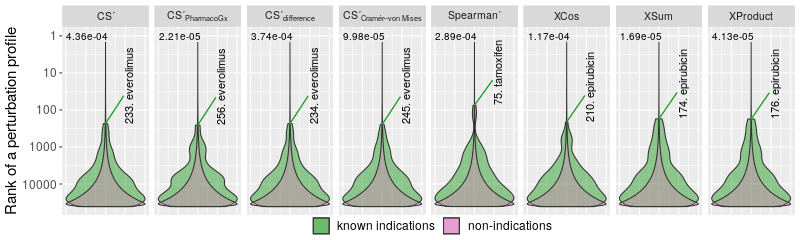

In [1039]:
%%R -i scores -w 800 -h 240 -i annotations

levels(scores$func)[levels(scores$func)=="CS'_{difference} (RGES)"] <- "CS'_{difference}"
levels(annotations$func)[levels(annotations$func)=="CS'_{difference} (RGES)"] <- "CS'_{difference}"

levels(scores$func) = sapply(levels(scores$func), latex2exp::TeX, 'expression')
levels(annotations$func) = sapply(levels(annotations$func), latex2exp::TeX, 'expression')

group_for_annotations <- 'known indications'

annotate_top_recovery = function(annotations, color='black', ...) {
    ggrepel::geom_text_repel(
        data=annotations,
        aes(
            label=best_label,
            y=best_recovery,
            fill=group_for_annotations,
            x=1,
            group=group_for_annotations,
            color=group_for_annotations,
            hjust=0,
            vjust=0,
        ),
        seed=0,
        nudge_y=0,
        nudge_x=0.25,
        max.iter=0,
        angle=90,
        segment.color='#2CA02C',
        fill='white',
        color=color,
        ...
    )
}

g = (
    khinkali_plot(scores, what='perturbation profile', ncol=8)
    # annotate with the top recovered drug to show an example (and where we really are)
    + annotate_top_recovery(annotations, color='#eeeeee')
    + annotate_top_recovery(annotations, color='black')
    + khinkali_fill_colors()
    + khinkali_p_values(
        annotations, shadow=T, color='black',
        bg.color='#eeeeee', bg.r=0.3,
        size=3.5
    )
    + theme(
        legend.margin=margin(t=-1, unit='cm'),
        strip.text.x=element_text(size=10.5)
    )
    + ylab('Rank of a perturbation profile')
)
ggsave(file="single_sample_BRCA_among_all.png", plot=g, width=8*1.4, height=2.4*1.4, dpi=140)
g

### Scores similarity clustering 

In [826]:
from signature_scoring.evaluation.analysis import distance_matrix
show_source(distance_matrix)

In [827]:
matrix = distance_matrix(scores)
matrix

,Spearman',XSum,XProduct,XCos,Connectivity Score' (CS'),CS'_{difference} (RGES),CS'_{Cramér–von Mises},CS'_{PharmacoGx}
Spearman',0.0,0.979527,1.000000,0.224069,0.288454,0.289968,0.192871,0.337724
XSum,0.0,0.000000,0.067066,0.760789,0.720726,0.719180,0.788297,0.749600
XProduct,0.0,0.000000,0.000000,0.783091,0.746625,0.744732,0.807886,0.757518
XCos,0.0,0.000000,0.000000,0.000000,0.113312,0.112366,0.058644,0.116651
Connectivity Score' (CS'),0.0,0.000000,0.000000,0.000000,0.000000,0.011767,0.100946,0.126872
CS'_{difference} (RGES),0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.101767,0.126872
CS'_{Cramér–von Mises},0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.168418
CS'_{PharmacoGx},0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [828]:
from signature_scoring.evaluation.analysis import clusters_from_matrix
show_source(clusters_from_matrix)

In [829]:
clusters = clusters_from_matrix(matrix, 4)
clusters

{"Spearman'": 2,
 'XSum': 1,
 'XProduct': 1,
 'XCos': 0,
 "Connectivity Score' (CS')": 0,
 "CS'_{difference} (RGES)": 0,
 "CS'_{Cramér–von Mises}": 0,
 "CS'_{PharmacoGx}": 3}

### Performance plot 

Using substances with known status only.
 
Log loss and AUC ROC based on sklearn implementation.

In [818]:
from signature_scoring.evaluation.analysis import compute_metrics_by_func, compute_metrics

In [819]:
metrics_by_func = compute_metrics_by_func(scores, without_unassigned=True)
metrics_by_func

,auc,auc0.01,auc0.1,func,log_loss
0,0.644535,0.515000,0.566285,Spearman',0.780856
1,0.652723,0.517293,0.592335,XSum,0.542249
2,0.652997,0.517293,0.592935,XProduct,0.539130
3,0.638696,0.507986,0.537283,XCos,0.716898
4,0.637008,0.508261,0.537775,Connectivity Score' (CS'),0.722332
5,0.636917,0.508261,0.537415,CS'_{difference} (RGES),0.721823
6,0.640042,0.509545,0.542109,CS'_{Cramér–von Mises},0.736055
7,0.635446,0.502806,0.544293,CS'_{PharmacoGx},0.701705


Note AUC 0.01 does not make much sense in this case as there are only a couple of substances at this level (5?).

But anyway, overall AUC and at 0.1/0.01 thresholds is kind of similar / correlated among functions:

In [820]:
metrics_by_func[['auc', 'auc0.1', 'auc0.01']].rank()

,auc,auc0.1,auc0.01
0,6.0,6.0,6.0
1,7.0,7.0,7.5
2,8.0,8.0,7.5
3,4.0,1.0,2.0
4,3.0,3.0,3.5
5,2.0,2.0,3.5
6,5.0,4.0,5.0
7,1.0,5.0,1.0


In [821]:
from scipy.stats import spearmanr

In [822]:
for c in ['auc0.1', 'auc0.01']:
    print(c, spearmanr(metrics_by_func[c], metrics_by_func.auc))

auc0.1 SpearmanrResult(correlation=0.6904761904761906, pvalue=0.057990318164572716)
auc0.01 SpearmanrResult(correlation=0.9157291161525718, pvalue=0.0014031743248924412)


In [823]:
nice_names_short = {
    **nice_single_sample_function_names,
    **{"connectivity_score_signature_kolmogorov_smirnov_conditional_difference": "CS'"}
}

In [824]:
def functions_summary_frame(result, clusters, metrics, nice_names):
    timings = result.Time.reset_index()
    timings.columns = timings.columns.str.lower()
    timings['func'] = timings.func.map(nice_names)
    
    clusters_df = Series(clusters).reset_index().rename({'index': 'func', 0: 'cluster'}, axis=1)

    summary = metrics.merge(timings).merge(clusters_df)
    
    summary.cluster = pd.Categorical(summary.cluster.astype(str))
    summary = summary.assign(time_rank=summary.time.rank())
    return summary

In [830]:
single_sample_summary = functions_summary_frame(
    results_single_sample, clusters,
    metrics_by_func, nice_names_short
)
single_sample_summary

,auc,auc0.01,auc0.1,func,log_loss,time,cluster,time_rank
0,0.644535,0.515000,0.566285,Spearman',0.780856,286.774986,2,1.0
1,0.652723,0.517293,0.592335,XSum,0.542249,287.927841,1,2.0
2,0.652997,0.517293,0.592935,XProduct,0.539130,328.372540,1,4.0
3,0.638696,0.507986,0.537283,XCos,0.716898,324.445174,0,3.0
4,0.636917,0.508261,0.537415,CS'_{difference} (RGES),0.721823,339.457864,0,5.0
5,0.640042,0.509545,0.542109,CS'_{Cramér–von Mises},0.736055,345.671334,0,6.0
6,0.635446,0.502806,0.544293,CS'_{PharmacoGx},0.701705,3680.535241,3,7.0


Some functions may refuse to work with certain signatures, though it should be highly exceptional:

In [831]:
def count_substances(scores):
    return (
        scores.groupby('func').pert_iname.apply(
            lambda x: len(set(x))
        ).to_dict()
    )

substances_count = count_substances(scores)
substances_count

{"Connectivity Score' (CS')": 5424,
 "CS'_{PharmacoGx}": 5424,
 "CS'_{difference} (RGES)": 5424,
 "CS'_{Cramér–von Mises}": 5424,
 "Spearman'": 5424,
 'XCos': 5424,
 'XSum': 5424,
 'XProduct': 5424}

In [832]:
def nice_time(t):
    # t is in seconds
    if t > 60*60:
        return f'{t//60:.0f}m {t - t//60*60:.0f}s'
    if t < 1:
        return f'{round(t * 1000)} ms'
    else:
        return f'{t:.2f}s'

def add_time_per_substance(summary, substances_count):
    summary['time_per_substance'] = summary.apply(
        lambda t: t['time'] / substances_count[t['func']],
        axis=1
    )
    summary['time_nice'] = summary.time_per_substance.apply(nice_time)
    return summary

In [833]:
single_sample_summary = add_time_per_substance(single_sample_summary, substances_count)
single_sample_summary

,auc,auc0.01,auc0.1,func,log_loss,time,cluster,time_rank,time_per_substance,time_nice
0,0.644535,0.515000,0.566285,Spearman',0.780856,286.774986,2,1.0,0.052871,53 ms
1,0.652723,0.517293,0.592335,XSum,0.542249,287.927841,1,2.0,0.053084,53 ms
2,0.652997,0.517293,0.592935,XProduct,0.539130,328.372540,1,4.0,0.060541,61 ms
3,0.638696,0.507986,0.537283,XCos,0.716898,324.445174,0,3.0,0.059817,60 ms
4,0.636917,0.508261,0.537415,CS'_{difference} (RGES),0.721823,339.457864,0,5.0,0.062584,63 ms
5,0.640042,0.509545,0.542109,CS'_{Cramér–von Mises},0.736055,345.671334,0,6.0,0.063730,64 ms
6,0.635446,0.502806,0.544293,CS'_{PharmacoGx},0.701705,3680.535241,3,7.0,0.678565,679 ms


#### Adding random scores performance:

In [852]:
def random_scores_metrics(random_result, are_grouped_by_cell):
    if len(random_result.index) != len(random_result.index.unique()):
        random_result.index = random_result.index + '_' + Series(
            map(str, range(len(random_result)))
        )
    random_scores = extract_scores_from_result(
        random_result['meta:Scores'],
        scores_as_series=False,
        are_grouped_by_cell=are_grouped_by_cell
    )
    random_scores = normalize_scores(random_scores, rescale=True, by_cell=are_grouped_by_cell)
    random_scores = add_helper_columns(random_scores)
    return compute_metrics_by_func(random_scores, without_unassigned=True)

In [853]:
random_metrics_ss = random_scores_metrics(single_sample_random_results, are_grouped_by_cell=True)
random_metrics_ss.head()

,auc,auc0.01,auc0.1,func,log_loss
0,0.538774,0.498496,0.519397,ss_random_normal_score_0,0.774775
1,0.523515,0.501797,0.509721,ss_random_normal_score_1,0.814602
2,0.476690,0.502943,0.489170,ss_random_normal_score_2,0.917642
3,0.510150,0.501934,0.493035,ss_random_normal_score_3,0.620361
4,0.476759,0.498496,0.490154,ss_random_normal_score_4,0.742760


In [863]:
%%R
source('../../helpers/plots/utilities.R')

performance_plot = function(
    s, random, outlier_cutoff, margin=0.5, adjustment=c(log_loss_gird_extend_left=0),
    left=c(breaks.zoom=1, minor_breaks.zoom=10),
    right=c(breaks.zoom=1, minor_breaks.zoom=10),
    up=c(unit='ms', factor=1000),
    label.theme=list(
        angle=0, size=9,
        vjust=7.25, color='white'
    )
) {
    s$auc_scaled = trans(s$auc, s$auc, margin)
    s$log_loss_scaled = trans(s$log_loss, s$log_loss, margin)

    s$func = sapply(s$func, latex2exp::TeX, 'character')
    s$func = sapply(s$func, function(l) paste("bold(", l, ")"))
    outlierts = s$time > outlier_cutoff
    s$time_outlier = NA
    s$time_outlier[outlierts] = 'outlier'

    breaks_auc = trans_seq(s$auc, margin=margin, side=-1, zoom=left['breaks.zoom'])
    breaks_loss = trans_seq(s$log_loss, margin=margin, side=+1, zoom=right['breaks.zoom'], start_adjustment=adjustment['log_loss_gird_extend_left'])
    
    g = (
        ggplot(s, aes(y=time_rank))
        + geom_segment(aes(x=0, xend=0, y=min(time_rank), yend=max(time_rank)), color='grey')
        + geom_segment(aes(x=-auc_scaled, xend=log_loss_scaled, y=time_rank, yend=time_rank), color='grey')
        + geom_point(aes(color=cluster, x=log_loss_scaled), size=11)
        + geom_point(aes(color=cluster, x=-auc_scaled), size=11)
        + shadowtext::geom_shadowtext(
            aes(
                label=substring(sprintf("%.3f", round(auc, digits=5)), 2),
                x=-auc_scaled
            ),
            color='white',
            bg.r=0.05,
            bg.color='#999999',
            size=3.3
        )
        + shadowtext::geom_shadowtext(
            aes(
                label=sprintf("%0.2f", round(log_loss, digits=2)),
                x=log_loss_scaled
            ),
            color='white',
            bg.r=0.05,
            bg.color='#999999',
            size=3.3
        )
        + geom_label(
            data=s[!outlierts,], aes(label=func, x=0, fill=time_per_substance * as.numeric(up[['factor']])), color='white', parse=T, size=3.1, label.padding=unit(0.3, 'lines'))
        + scale_fill_gradient(
            low="#00B700", high="#EABB41",
            labels=function(x) sprintf("%.0f", x)
        )
        + shadowtext::geom_shadowtext(
            aes(label=time_nice, x=0),
            color='black', position=position_nudge(y=-0.3),
            bg.color='white',
            bg.r=0.2,
            size=2.6
        )
        + xlab('← AUC ROC\t\t     \t\tLog Loss → ')
        + theme_minimal()
        + theme(
            legend.position='bottom',
            legend.box='horizontal',
            text=element_text(size=10),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),

        )
        + ylab('')
        + guides(
            color=guide_legend(
                title='Cluster',
                label=F,
                keywidth=.5,
                override.aes=list(size=5)
            ),
            fill=guide_colorbar(
                label=T,
                title=sprintf('Time per substance [%s]', up['unit']),
                label.position = "bottom",
                title.theme = element_text(vjust=0.85, size=10),
                label.theme = do.call(element_text, label.theme)
            )
        )
        + scale_x_continuous(
            minor_breaks=c(
                trans_seq(s$auc, margin=margin, side=-1, zoom=left['minor_breaks.zoom'], end_shift=0.01),
                trans_seq(s$log_loss, margin=margin, side=+1, zoom=right['minor_breaks.zoom'], end_shift=0.01)
            ),
            breaks=c(
                breaks_auc,
                breaks_loss
            ),
            labels=c(
                labels_seq(s$auc, side=-1, zoom=left['breaks.zoom'])[1:length(breaks_auc)],
                labels_seq(s$log_loss, side=+1, zoom=right['breaks.zoom'])[1:length(breaks_loss)]
            )
        )
        + annotate('text', x=-(1.1 + margin), y=max(s$time_rank) + 0.5, label=sprintf(
            "Expected: %.2f ± %.2f", median(random$auc), sd(random$auc)),
            hjust=0, size=3.1, color='#666666'
        )
        + annotate('text', x=+(1.1 + margin), y=max(s$time_rank) + 0.5, label=sprintf(
            "Expected: %.2f ± %.2f", median(random$log_loss), sd(random$log_loss)),
            hjust=1, size=3.1, color='#666666'
        )
    )
    
    if(any(outlierts)) {
        g = (
            g
            + geom_label(
                data=s[outlierts,], 
                aes(label=func, x=0, group=time_per_substance),
                show.legend='group',
                fill='#FF3900', color='white',
                parse=T, size=3.1, label.padding=unit(0.3, 'lines')
            )
        )
    }
    (
        g
        + shadowtext::geom_shadowtext(aes(label=func, x=0), parse=T, size=3.1, bg.r=0.05, bg.color='#888888')
        + scale_color_manual(
            values=c(
                '#499894',
                '#8C564B',
                '#1F77B4',
                '#17BECF'
            ),
            guide=guide_legend(
                title='Category',
                direction='vertical',
                title.position="left"
            )
        )
    )
}

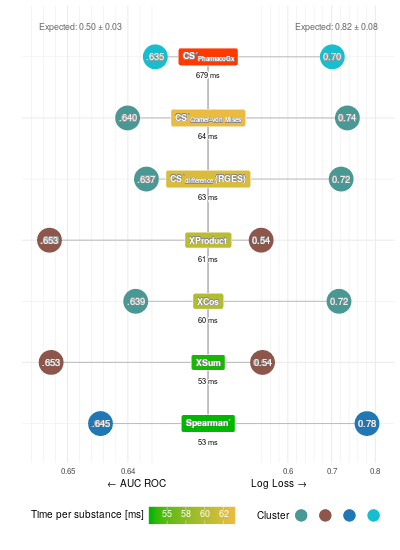

In [864]:
%%R -i single_sample_summary -i random_metrics_ss -w 400 -h 550 -u px
single_sample_comparison = performance_plot(
    single_sample_summary, random_metrics_ss, outlier_cutoff=60*60,
    adjustment=c(log_loss_gird_extend_left=0.05),
    left=c(breaks.zoom=100, minor_breaks.zoom=500),
    right=c(breaks.zoom=10, minor_breaks.zoom=50)
)
ggsave(
    file="single_sample_BRCA_comparison.png",
    plot=single_sample_comparison,
    width=4*1.3, height=5.5*1.3, dpi=350
)
single_sample_comparison

We want the log loss to be low and AUC ROC to be high (see examples in Methods_overview.py)

### Chosen functions:

- Spearman': high AUC ROC, low log loss - such a good result is surprising given that previous publications disregarded simple correlation approaches (Cheng 2013? and RGES - they have some table in excel with benchmark summary, I need to find it for write up),
- XSum: high AUC ROC, better log loss and execution time than XProduct,
- $CS'_{CramerVonMises}$: very similar to XCos and RGES, but better in both metrics; unfortunately a bit slower

In [44]:
%%capture
from Benchmarking_setup import (
    connectivity_score_cramér_von_mises,
    x_sum,
    score_spearman
)
selected_single_sample_functions = [
    connectivity_score_cramér_von_mises,
    x_sum,
    score_spearman
]

## Multi-sample

In [ ]:
results_multi_sample_all = brca_minimal_benchmark(
    # using minimal benchmark (indications and contraindications only) as multi-sample functions:
    # 1. are slow - so it takes to much time to compute values for all unassigned signatures,
    # 2. need controls - and there are no controls for controls
    tested_multi_sample_functions
)

In [136]:
# %store results_multi_sample_all

Stored 'results_multi_sample_all' (DataFrame)


In [635]:
%store -r results_multi_sample_all

### Processing

In [638]:
multi_sample_scores = extract_scores_from_result(
    results_multi_sample_all['meta:Scores'],
    scores_as_series=False,
    are_grouped_by_cell=False
)
#multi_sample_scores.to_csv('results_multi_sample.csv', index=False)

In [639]:
from Plotting import nice_multi_sample_function_names

In [33]:
from signature_scoring.post_processing import process_scores
show_source(process_scores)

In [641]:
multi_sample_scores = read_csv('results_multi_sample.csv', index_col=0).reset_index()
multi_sample_scores = process_scores(multi_sample_scores, nice_multi_sample_function_names)

In [642]:
multi_sample_scores.head()

,Index,func,group,pert_idose,pert_iname,score,raw_score,is_indication,known_indication,rank
0,0,PLAGE,indications,10 µM,everolimus,1.000000,2.020610,True,known indications,1.0
1,1,PLAGE,indications,1 µM,methotrexate,0.877594,1.748053,True,known indications,3.0
2,2,PLAGE,indications,10 µM,methotrexate,0.877594,1.748053,True,known indications,4.0
3,3,PLAGE,indications,500 nM,lapatinib,0.675978,1.299122,True,known indications,5.0
4,4,PLAGE,indications,10 µM,lapatinib,0.675978,1.299122,True,known indications,6.0


GSVA-implemented functions failed to process data for fluoxymesterone (20 µM):

In [643]:
multi_sample_scores[multi_sample_scores.score.isnull()]

,Index,func,group,pert_idose,pert_iname,score,raw_score,is_indication,known_indication,rank
74,49,PLAGE,contraindications,20 µM,fluoxymesterone,NaN,NaN,False,non-indications,NaN
149,49,GSVA,contraindications,20 µM,fluoxymesterone,NaN,NaN,False,non-indications,NaN
224,49,ssGSEA (GSVA),contraindications,20 µM,fluoxymesterone,NaN,NaN,False,non-indications,NaN
299,49,z-score,contraindications,20 µM,fluoxymesterone,NaN,NaN,False,non-indications,NaN


and these scores were dropped:

In [644]:
multi_sample_scores = multi_sample_scores.dropna()

### Distribution plot

/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


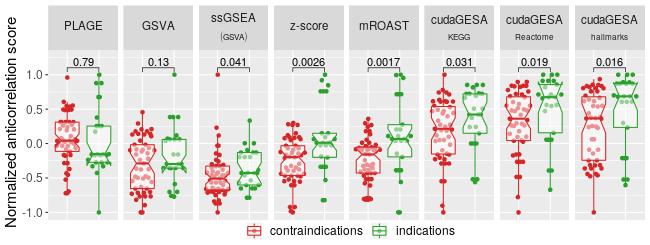

In [1100]:
%%R -i multi_sample_scores -w 650 -h 245

levels(multi_sample_scores$func)[levels(multi_sample_scores$func)=="ssGSEA (GSVA)"] <- "atop(ssGSEA, atop(scriptstyle((GSVA))))"
levels(multi_sample_scores$func)[levels(multi_sample_scores$func)=="cudaGSEA_{KEGG}"] <- "atop(cudaGESA, atop(scriptstyle(KEGG), NA))"
levels(multi_sample_scores$func)[levels(multi_sample_scores$func)=="cudaGSEA_{Reactome}"] <- "atop(cudaGESA, atop(scriptstyle(Reactome), NA))"
levels(multi_sample_scores$func)[levels(multi_sample_scores$func)=="cudaGSEA_{hallmarks}"] <- "atop(cudaGESA, atop(scriptstyle(hallmarks), NA))"

levels(multi_sample_scores$func)[levels(multi_sample_scores$func)=="PLAGE"] <- "atop(atop(NA, displaystyle(PLAGE)), NA)"
levels(multi_sample_scores$func)[levels(multi_sample_scores$func)=="mROAST"] <- "atop(atop(NA, displaystyle(mROAST)), NA)"
levels(multi_sample_scores$func)[levels(multi_sample_scores$func)=="GSVA"] <- "atop(atop(NA, displaystyle(GSVA)), NA)"
levels(multi_sample_scores$func)[levels(multi_sample_scores$func)=="z-score"] <- "atop(atop(NA, displaystyle(`z-score`)), NA)"


g = (
    distribution_plot(
        multi_sample_scores,
        to_compare=list(
            c("indications", "contraindications")
        ),
        ncol=8,
        top_lim=1.25,
        parse=F
    ) 
    + theme(
        #legend.margin=margin(t=-1, unit='cm'),
        strip.text.x=element_text(size=11.6, margin = margin(0.2,0,-0.15,0, "cm"))
    )
    + ylab('      Normalized anticorrelation score')
)
ggsave(file="multi_sample_BRCA_small.png", plot=g, width=6.5*1.3, height=2.5*1.3, dpi=140)
g

### The PLAGE issue

In [664]:
results_multi_sample_all['contraindications:Is Mean Better']

Func
plage_None_mx_diff:True                                                             False
gsva_None_mx_diff:True                                                               True
ssgsea_None_mx_diff:True                                                             True
zscore_None_mx_diff:True                                                             True
roast_score                                                                          True
cudaGSEA_1000_c2.cp.kegg_mean_0.5_fill_0_True_phenotype_twopass_signal2noise         True
cudaGSEA_1000_c2.cp.reactome_mean_0.5_fill_0_True_phenotype_twopass_signal2noise     True
cudaGSEA_1000_h.all_mean_0.5_fill_0_True_phenotype_twopass_signal2noise              True
Name: contraindications:Is Mean Better, dtype: bool

Although PLAGE got lower mean for contraindications than indications, we can still give it a benefit of a doubt and inverse the scores (as for the classification task, the sign does not matter in the end if we can tell which group is which):

In [675]:
plage_rows = multi_sample_scores.func == 'PLAGE'
plage_subset = multi_sample_scores[plage_rows]
plage_subset.score = -plage_subset.score

Even if we do reverse the scores, the difference in distributions is not significant (and still, the worst of all tested functions):

In [676]:
%%R -i plage_subset

indications = plage_subset[plage_subset$group=='indications',]
contraindications = plage_subset[plage_subset$group=='contraindications',]

wilcox.test(indications$score, contraindications$score, alternative='greater')

/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))



	Wilcoxon rank sum test with continuity correction

data:  indications$score and contraindications$score
W = 682, p-value = 0.2152
alternative hypothesis: true location shift is greater than 0



This result was consistent across multiple runs and highly suspicious, given the reports of good PLAGE performance and the use of implementation from GSVA package (same as for GSVA, zscore, and ssgsea - which performed ok), where one could expect that all the functions will report scores in the same direction.

However, for the top 10 percentile, the PLAGE results were actually not that bad:

In [677]:
plage_subset = multi_sample_scores[plage_rows]

In [678]:
plage_subset[plage_subset.score > plage_subset.score.quantile(.9)].sort_values(
    'score', ascending=False
)

,Index,func,group,pert_idose,pert_iname,score,raw_score,is_indication,known_indication
0,0,PLAGE,indications,10 µM,everolimus,1.000000,2.020610,True,known indications
25,0,PLAGE,contraindications,10 µM,ethynodiol,0.958463,1.928122,False,non-indications
1,1,PLAGE,indications,1 µM,methotrexate,0.877594,1.748053,True,known indications
2,2,PLAGE,indications,10 µM,methotrexate,0.877594,1.748053,True,known indications
3,3,PLAGE,indications,500 nM,lapatinib,0.675978,1.299122,True,known indications
4,4,PLAGE,indications,10 µM,lapatinib,0.675978,1.299122,True,known indications
26,1,PLAGE,contraindications,10 µM,quetiapine,0.606036,1.143386,False,non-indications
27,2,PLAGE,contraindications,10 µM,phylloquinone,0.552324,1.023788,False,non-indications


As it highly ranked 5 indications over only 3 contraindications profiles (though an equal number of indicated and contraindicated substances)

### Similarity clustering

In [868]:
matrix = distance_matrix(multi_sample_scores)

In [869]:
clusters = clusters_from_matrix(matrix, 4)
clusters

{'PLAGE': 2,
 'GSVA': 0,
 'ssGSEA (GSVA)': 3,
 'z-score': 0,
 'mROAST': 0,
 'cudaGSEA_{KEGG}': 1,
 'cudaGSEA_{Reactome}': 1,
 'cudaGSEA_{hallmarks}': 1}

### Performance plot

In [910]:
multi_sample_scores

,Index,func,group,pert_idose,pert_iname,score,raw_score,is_indication,known_indication,rank
0,0,PLAGE,indications,10 µM,everolimus,1.000000,2.020610,True,known indications,1.0
1,1,PLAGE,indications,1 µM,methotrexate,0.877594,1.748053,True,known indications,3.0
2,2,PLAGE,indications,10 µM,methotrexate,0.877594,1.748053,True,known indications,4.0
3,3,PLAGE,indications,500 nM,lapatinib,0.675978,1.299122,True,known indications,5.0
4,4,PLAGE,indications,10 µM,lapatinib,0.675978,1.299122,True,known indications,6.0
...,...,...,...,...,...,...,...,...,...,...
585,42,cudaGSEA_{hallmarks},contraindications,20 µM,oxymetholone,-0.441631,0.403419,False,non-indications,65.0
586,43,cudaGSEA_{hallmarks},contraindications,10 µM,oxymetholone,-0.441631,0.403419,False,non-indications,66.0
587,44,cudaGSEA_{hallmarks},contraindications,10 µM,dienestrol,-0.461521,0.397417,False,non-indications,67.0
588,45,cudaGSEA_{hallmarks},contraindications,10 µM,iloperidone,-0.475474,0.393207,False,non-indications,68.0


In [883]:
metrics_by_func = compute_metrics_by_func(multi_sample_scores, without_unassigned=True)
metrics_by_func

,auc,auc0.01,auc0.1,func,log_loss
0,0.443265,0.517588,0.561762,PLAGE,1.263318
1,0.581224,0.517588,0.545005,GSVA,0.652459
2,0.624490,0.497487,0.506767,ssGSEA (GSVA),1.088804
3,0.699592,0.618090,0.607734,z-score,0.591483
4,0.710204,0.618090,0.620193,mROAST,1.457109
5,0.634894,0.497487,0.552520,cudaGSEA_{KEGG},1.283801
6,0.650213,0.618090,0.612094,cudaGSEA_{Reactome},0.972176
7,0.654468,0.557789,0.636282,cudaGSEA_{hallmarks},0.962467


In [871]:
substances_count = count_substances(multi_sample_scores)
substances_count

{'PLAGE': 54,
 'GSVA': 54,
 'ssGSEA (GSVA)': 54,
 'z-score': 54,
 'mROAST': 54,
 'cudaGSEA_{KEGG}': 52,
 'cudaGSEA_{Reactome}': 52,
 'cudaGSEA_{hallmarks}': 52}

In [911]:
results_multi_sample_all

,Time,contraindications:AUC ROC,contraindications:AUC ROC classification,contraindications:F1 Score,contraindications:Indications Prioritized,...,indications:Recall,meta:Scores,meta:Selected substances,overall:AUC ROC classification,overall:RMSE
Func,,,,,,,,,,,
plage_None_mx_diff:True,165.402161,NaN,0.570000,0.103448,0.020000,...,0.20,NeatNamespace(contraindications= ...,8,0.570000,NaN
gsva_None_mx_diff:True,297.310963,NaN,0.540000,0.137931,0.020000,...,0.16,NeatNamespace(contraindications= ...,8,0.540000,NaN
ssgsea_None_mx_diff:True,373.318181,NaN,0.510000,0.172414,0.000000,...,0.12,NeatNamespace(contraindications= ...,8,0.510000,NaN
zscore_None_mx_diff:True,165.118168,NaN,0.600000,0.068966,0.120000,...,0.24,NeatNamespace(contraindications= ...,8,0.600000,NaN
roast_score,110.578284,0.710204,0.599592,0.070175,0.122449,...,0.24,NeatNamespace(contraindications= ...,8,0.599592,0.907127
cudaGSEA_1000_c2.cp.kegg_mean_0.5_fill_0_True_phenotype_twopass_signal2noise,79.616837,0.634894,0.537447,0.145455,0.000000,...,0.16,NeatNamespace(contraindications= ...,8,0.537447,1.113981
cudaGSEA_1000_c2.cp.reactome_mean_0.5_fill_0_True_phenotype_twopass_signal2noise,95.923420,0.650213,0.598723,0.072727,0.127660,...,0.24,NeatNamespace(contraindications= ...,8,0.598723,1.182615
cudaGSEA_1000_h.all_mean_0.5_fill_0_True_phenotype_twopass_signal2noise,74.858042,0.654468,0.609362,0.037037,0.063830,...,0.24,NeatNamespace(contraindications= ...,7,0.609362,1.168358


In [880]:
multi_sample_summary = functions_summary_frame(
    results_multi_sample_all, clusters,
    metrics_by_func, nice_multi_sample_function_names
)
multi_sample_summary = add_time_per_substance(multi_sample_summary, substances_count)
multi_sample_summary

,auc,auc0.01,auc0.1,func,log_loss,time,cluster,time_rank,time_per_substance,time_nice
0,0.443265,0.517588,0.561762,PLAGE,1.263318,165.402161,2,6.0,3.063003,3.06s
1,0.581224,0.517588,0.545005,GSVA,0.652459,297.310963,0,7.0,5.505759,5.51s
2,0.624490,0.497487,0.506767,ssGSEA (GSVA),1.088804,373.318181,3,8.0,6.913300,6.91s
3,0.699592,0.618090,0.607734,z-score,0.591483,165.118168,0,5.0,3.057744,3.06s
4,0.710204,0.618090,0.620193,mROAST,1.457109,110.578284,0,4.0,2.047746,2.05s
5,0.634894,0.497487,0.552520,cudaGSEA_{KEGG},1.283801,79.616837,1,2.0,1.531093,1.53s
6,0.650213,0.618090,0.612094,cudaGSEA_{Reactome},0.972176,95.923420,1,3.0,1.844681,1.84s
7,0.654468,0.557789,0.636282,cudaGSEA_{hallmarks},0.962467,74.858042,1,1.0,1.439578,1.44s


In [884]:
random_metrics_ms = random_scores_metrics(
    multi_sample_random_results,
    are_grouped_by_cell=False
)

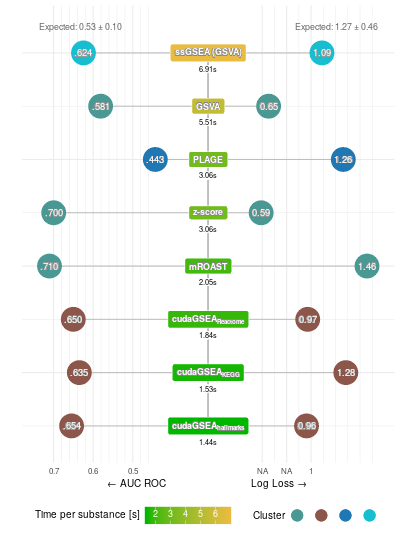

In [885]:
%%R -i multi_sample_summary -i random_metrics_ms -w 400 -h 550
multi_sample_comparison = performance_plot(
    multi_sample_summary, random_metrics_ms, outlier_cutoff=60*60,
    left=c(breaks.zoom=10, minor_breaks.zoom=50),
    right=c(breaks.zoom=5, minor_breaks.zoom=10),
    up=c(
        unit='s',
        factor=1
    )
)
ggsave(
    file="multi_sample_BRCA_comparison.png",
    plot=multi_sample_comparison,
    width=4*1.3, height=5.5*1.3, dpi=350
)
multi_sample_comparison

### Chosen functions

- cudaGSEA Reactome (best log loss, good AUC),
- cudaGSEA hallmarks (best AUC),
- mROAST (faster than z-scorre, slightly better in both metrics).

Disqualified:
- ssGSEA: slowest, log loss worse than random
- PLAGE: slow, AUC worse than random

In [1521]:
from Benchmarking_setup import (
    gsea_score_phenotypes_cuda_hallmarks,
    gsea_score_phenotypes_cuda_reactome,
    roast_score_by_substance
)
selected_multi_sample_functions = [
    gsea_score_phenotypes_cuda_hallmarks,
    gsea_score_phenotypes_cuda_reactome,
    roast_score_by_substance
]

## Single sample and multi sample comparison

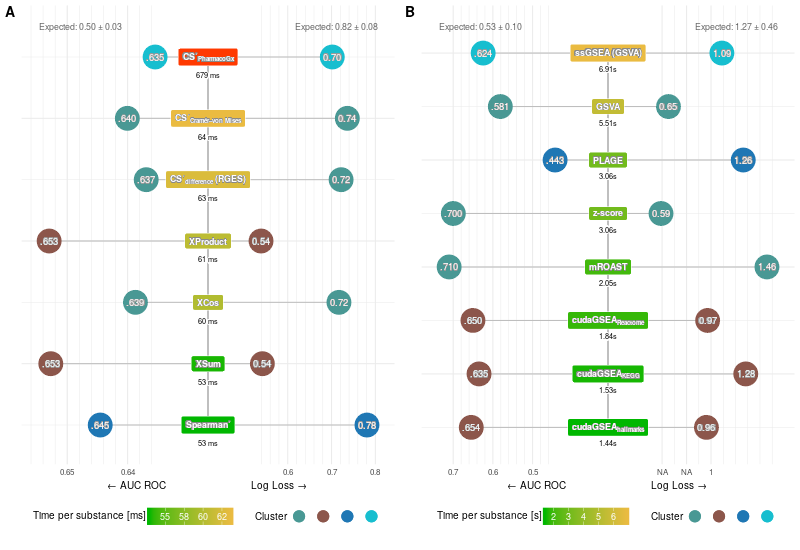

In [912]:
%%R -w 800 -h 550
comparison = cowplot::plot_grid(
    single_sample_comparison,
    multi_sample_comparison,
    labels = c('A', 'B')
)
ggsave(
    file="BRCA_comparison.png",
    plot=comparison,
    width=2*4*1.45, height=5.5*1.45, dpi=140
)
comparison

A is per perturbation profile, B is per substance.

This makes a difference, as there are unequal numbers of profiles per substances. So it is biased, giving more weight to the substances with more profiles. There may be more profiles of known drugs - this would be a sensible choice if the authors of CMap were to make one (though it is just an assumption), though making the metric values more extreme. Let's see how it would (A) work per-substance: 

In [39]:
ss_scores_by_substance = copy(scores)
ss_scores_by_substance['score'] = ss_scores_by_substance.groupby(['func', 'pert_iname'])['score'].transform('mean')
ss_scores_by_substance = ss_scores_by_substance[ss_scores_by_substance.columns.difference(['pert_idose', 'cell_id', 'Index', 'raw_score'])].drop_duplicates()

In [41]:
show_table(ss_scores_by_substance.sort_values('pert_iname'))

,func,group,is_indication,known_indication,pert_iname,score
165829,Connectivity Score' (CS'),unassigned,False,non-indications,"1,2,3,4,5,6-hexabromocyclohexane",0.098454
43580,XSum,unassigned,False,non-indications,"1,2,3,4,5,6-hexabromocyclohexane",-0.298993
206611,CS'_{difference} (RGES),unassigned,False,non-indications,"1,2,3,4,5,6-hexabromocyclohexane",0.097686
124982,XCos,unassigned,False,non-indications,"1,2,3,4,5,6-hexabromocyclohexane",0.103653
84310,XProduct,unassigned,False,non-indications,"1,2,3,4,5,6-hexabromocyclohexane",-0.312833
247383,CS'_{Cramér–von Mises},unassigned,False,non-indications,"1,2,3,4,5,6-hexabromocyclohexane",0.101575
2013,Spearman',unassigned,False,non-indications,"1,2,3,4,5,6-hexabromocyclohexane",0.241263
288324,CS'_{PharmacoGx},unassigned,False,non-indications,"1,2,3,4,5,6-hexabromocyclohexane",0.068959
168258,Connectivity Score' (CS'),unassigned,False,non-indications,"1,2-dichlorobenzene",-0.158361
86652,XProduct,unassigned,False,non-indications,"1,2-dichlorobenzene",-0.408749


In [40]:
metrics_by_func = compute_metrics_by_func(ss_scores_by_substance, without_unassigned=True)
metrics_by_func

,auc,auc0.01,auc0.1,func,log_loss
0,0.660714,0.497487,0.625506,Spearman',1.467340
1,0.660714,0.641062,0.654425,XSum,6.374553
2,0.666209,0.641062,0.654425,XProduct,6.840103
3,0.655220,0.497487,0.574899,XCos,2.397683
4,0.659341,0.497487,0.589358,Connectivity Score' (CS'),2.403494
5,0.660714,0.497487,0.589358,CS'_{difference} (RGES),2.403992
6,0.651099,0.497487,0.582128,CS'_{Cramér–von Mises},2.397916
7,0.651099,0.497487,0.582128,CS'_{PharmacoGx},2.413433


In [71]:
ss_scores_by_substance[ss_scores_by_substance.func=="Spearman'"].sort_values('pert_iname')

,func,group,is_indication,known_indication,pert_iname,score
2013,Spearman',unassigned,False,non-indications,"1,2,3,4,5,6-hexabromocyclohexane",0.241263
4330,Spearman',unassigned,False,non-indications,"1,2-dichlorobenzene",0.058855
5027,Spearman',unassigned,False,non-indications,1-benzylimidazole,0.080554
3080,Spearman',unassigned,False,non-indications,1-monopalmitin,-0.008391
5054,Spearman',unassigned,False,non-indications,1-phenylbiguanide,0.094088
...,...,...,...,...,...,...
1686,Spearman',unassigned,False,non-indications,zolpidem,0.100713
3103,Spearman',unassigned,False,non-indications,zonisamide,0.132137
3677,Spearman',unassigned,False,non-indications,zosuquidar,0.182266
1786,Spearman',unassigned,False,non-indications,zoxazolamine,0.257141


## Single-sample gene-set based functions

Which were basically to slow to include them in the full benchmarks above:

In [63]:
functions_names(single_sample_gene_set_based)

['plage_100_mx_diff:True_single_sample',
 'gsva_100_mx_diff:True_single_sample',
 'ssgsea_100_mx_diff:True_single_sample',
 'zscore_100_mx_diff:True_single_sample',
 'GSEADesktop_1000_c2.cp.kegg_mean_0.05_fill_0_True_Gene_set_Diff_of_Classes',
 'GSEADesktop_1000_c2.cp.reactome_mean_0.05_fill_0_True_Gene_set_Diff_of_Classes',
 'GSEADesktop_1000_h.all_mean_0.05_fill_0_True_Gene_set_Diff_of_Classes']

In [66]:
single_sample_gene_set = brca_minimal_benchmark(
    # minimal benchmark as these are way slower than everything else
    single_sample_gene_set_based
)

'GeneSetCohorted_scored: 501 / 1000'

'GeneSetCohorted: 501 / 1000'

'shuffleGeneSet for GeneSet 21/30 nperm: 1000'

'GeneSetCohorted: 501 / 1000'

'GeneSetCohorted: 501 / 1000'

'GeneSetCohorted_scored: 501 / 1000'

In [79]:
# %store single_sample_gene_set

Stored 'single_sample_gene_set' (DataFrame)


In [901]:
%store -r single_sample_gene_set

In [80]:
ss_gset_scores = extract_scores_from_result(
    single_sample_gene_set['meta:Scores'],
    scores_as_series=False
)

In [81]:
ss_gset_scores.to_csv('single_sample_gene_set_based_results.csv')

In [891]:
ss_names = {
    'plage_100_mx_diff:True_single_sample': 'PLAGE_{ss}',
    'gsva_100_mx_diff:True_single_sample': 'GSVA_{ss}',
    'ssgsea_100_mx_diff:True_single_sample': 'ssGSEA_{ss}',
    'zscore_100_mx_diff:True_single_sample': 'zScore_{ss}',
    'GSEADesktop_1000_c2.cp.kegg_mean_0.05_fill_0_True_Gene_set_Diff_of_Classes': 'GSEA_{KEGG}',
    'GSEADesktop_1000_c2.cp.reactome_mean_0.05_fill_0_True_Gene_set_Diff_of_Classes': 'GSEA_{Reactome}',
    'GSEADesktop_1000_h.all_mean_0.05_fill_0_True_Gene_set_Diff_of_Classes': 'GSEA_{hallmark}'
}

In [892]:
ss_gset_scores = read_csv('single_sample_gene_set_based_results.csv', index_col=0).reset_index()
ss_gset_scores = process_scores(ss_gset_scores, ss_names)

In [893]:
ss_gset_scores

,index,Index,cell_id,func,group,...,score,raw_score,is_indication,known_indication,rank
0,0,0,HCC515,PLAGE_{ss},indications,...,0.329744,0.353659,True,known indications,47.0
1,1,1,HCC515,PLAGE_{ss},indications,...,0.255383,0.319932,True,known indications,66.0
2,2,2,HCC515,PLAGE_{ss},indications,...,0.037734,0.221212,True,known indications,150.0
3,3,3,HCC515,PLAGE_{ss},indications,...,-0.009191,0.199928,True,known indications,172.0
4,4,4,HCC515,PLAGE_{ss},indications,...,-0.102807,0.157467,True,known indications,233.0
...,...,...,...,...,...,...,...,...,...,...,...
2935,2935,32,A549,GSEA_{hallmark},contraindications,...,-0.527043,-0.289128,False,non-indications,378.0
2936,2936,33,A549,GSEA_{hallmark},contraindications,...,-0.557535,-0.307967,False,non-indications,383.0
2937,2937,34,A549,GSEA_{hallmark},contraindications,...,-0.577197,-0.320116,False,non-indications,385.0
2938,2938,35,A549,GSEA_{hallmark},contraindications,...,-0.616204,-0.344218,False,non-indications,388.0


### Distribution plot

This one goes to the supplement (GSEA works fine, but it is too slow in this implementation)

/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


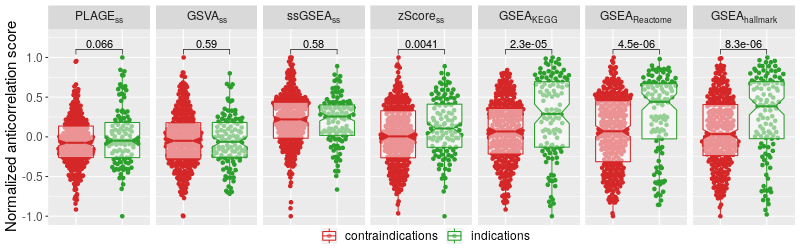

In [913]:
%%R -i ss_gset_scores -w 800 -h 250
g = distribution_plot(
    ss_gset_scores,
    to_compare=list(
        c("indications", "contraindications")
    ),
    ncol=7,
    top_lim=1.25
)
ggsave(file="ss_gene_set_distribution.png", plot=g, width=8*1.3, height=2.5*1.3, dpi=140)
g

In [895]:
matrix = distance_matrix(ss_gset_scores)

In [896]:
clusters = clusters_from_matrix(matrix, 4)

In [897]:
clusters

{'PLAGE_{ss}': 0,
 'GSVA_{ss}': 0,
 'ssGSEA_{ss}': 2,
 'zScore_{ss}': 3,
 'GSEA_{KEGG}': 1,
 'GSEA_{Reactome}': 1,
 'GSEA_{hallmark}': 1}

### Performance plot

In [898]:
metrics_by_func = compute_metrics_by_func(ss_gset_scores, without_unassigned=True)
metrics_by_func

,auc,auc0.01,auc0.1,func,log_loss
0,0.547981,0.509887,0.535220,PLAGE_{ss},0.778092
1,0.492894,0.497589,0.493149,GSVA_{ss},0.825584
2,0.493269,0.497487,0.488704,ssGSEA_{ss},1.002192
3,0.583984,0.497487,0.527968,zScore_{ss},0.911028
4,0.629673,0.560050,0.610274,GSEA_{KEGG},0.866747
5,0.641146,0.500587,0.565411,GSEA_{Reactome},0.894696
6,0.636938,0.508236,0.566928,GSEA_{hallmark},0.831647


In [899]:
substances_count = count_substances(ss_gset_scores)
substances_count

{'PLAGE_{ss}': 55,
 'GSVA_{ss}': 55,
 'ssGSEA_{ss}': 55,
 'zScore_{ss}': 55,
 'GSEA_{KEGG}': 55,
 'GSEA_{Reactome}': 55,
 'GSEA_{hallmark}': 55}

In [902]:
ss_summary = functions_summary_frame(
    single_sample_gene_set, clusters,
    metrics_by_func, ss_names
)
ss_summary = add_time_per_substance(ss_summary, substances_count)
ss_summary

,auc,auc0.01,auc0.1,func,log_loss,time,cluster,time_rank,time_per_substance,time_nice
0,0.547981,0.509887,0.535220,PLAGE_{ss},0.778092,15300.567905,0,6.0,278.192144,278.19s
1,0.492894,0.497589,0.493149,GSVA_{ss},0.825584,8926.146824,0,4.0,162.293579,162.29s
2,0.493269,0.497487,0.488704,ssGSEA_{ss},1.002192,10170.110696,2,5.0,184.911104,184.91s
3,0.583984,0.497487,0.527968,zScore_{ss},0.911028,16487.961725,3,7.0,299.781122,299.78s
4,0.629673,0.560050,0.610274,GSEA_{KEGG},0.866747,717.370521,1,1.0,13.043100,13.04s
5,0.641146,0.500587,0.565411,GSEA_{Reactome},0.894696,907.071054,1,3.0,16.492201,16.49s
6,0.636938,0.508236,0.566928,GSEA_{hallmark},0.831647,809.897047,1,2.0,14.725401,14.73s


In [903]:
random_metrics_ss = random_scores_metrics(
    ss_gene_sets_random_results,
    are_grouped_by_cell=True
)

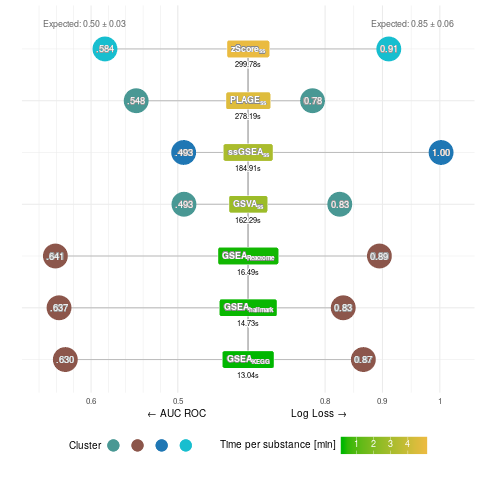

In [914]:
%%R -i ss_summary -i random_metrics_ss
g = performance_plot(
    ss_summary, random_metrics_ss, outlier_cutoff=60*60*60,
    left=c(breaks.zoom=10, minor_breaks.zoom=50),
    right=c(breaks.zoom=10, minor_breaks.zoom=20),
    up=c(
        unit='min',
        factor=1/60
    )
)
ggsave(file="ss_gene_set_BRCA_comparison.png", plot=g, width=4.5*1.3, height=5.5*1.3, dpi=140)
g

# In depth analysis with selected functions

Further analyses on MCF7 cell line (the only cell line originating from a patient with breast cancer among analyzed) were conducted using the six promising functions:

In [1139]:
functions_names(selected_single_sample_functions)

['connectivity_score_signature_cramér_von_mises_difference',
 'x_sum',
 'score_spearman']

In [1140]:
functions_names(selected_multi_sample_functions)

['cudaGSEA_1000_h.all_mean_0.5_fill_0_True_phenotype_twopass_signal2noise',
 'cudaGSEA_1000_c2.cp.reactome_mean_0.5_fill_0_True_phenotype_twopass_signal2noise',
 'roast_score']

First, I compute scores for all unassigned substances (such scores were not computed for multi-sample functions up until this point):

In [ ]:
results_multi_sample_selected = brca_standard_benchmark(
    funcs=selected_multi_sample_functions,
    indications_signatures=data_brca.indications_singatures,
    contraindications_signatures=data_brca.contraindications_singatures,
    unassigned_signatures=all_other_selected,
    processes=12
)

In [39]:
#%store results_multi_sample_selected

Stored 'results_multi_sample_selected' (DataFrame)


In [1]:
%store -r results_multi_sample_selected

And select relevant results from single sample calculations:

In [45]:
results_single_sample_selected = results_single_sample[results_single_sample.index.isin(
    functions_names(selected_single_sample_functions)
)]

In [46]:
#%store results_single_sample_selected

Stored 'results_single_sample_selected' (DataFrame)


In [32]:
def reload_and_process(scores, nice_names, save_path):
    if scores:
        scores.to_csv(save_path, index=False)
    scores = read_csv(save_path, index_col=0).reset_index()
    scores = process_scores(scores, nice_names)
    return scores

In [16]:
def n_best_in_group(scores, group):
    belongs_to_group = (scores.group == group)
    indications_by_func = scores[belongs_to_group].groupby('func')
    return n_best_scoring(scores, indications_by_func, n=5) 

In [49]:
# sss = Single Sample from Selected functions
sss_scores = extract_scores_from_result(
    results_single_sample_selected['meta:Scores'],
    scores_as_series=False
)
sss_scores.group = sss_scores.group.replace({'unknown_status': 'unassigned'})
# discard scores for controls (so we compare the same things)
sss_scores = sss_scores[sss_scores.group != 'controls']

### MCF7 cell line only (the breast cancer cell line):

In [ ]:
results_multi_sample_mcf7_selected = brca_standard_benchmark(
    funcs=selected_multi_sample_functions,
    indications_signatures=data_brca.indications_singatures,
    contraindications_signatures=data_brca.contraindications_singatures,
    unassigned_signatures=all_other_selected,
    processes=8,
    cell_lines={'MCF7'}
)

In [37]:
# %store results_multi_sample_mcf7_selected

Stored 'results_multi_sample_mcf7_selected' (DataFrame)


In [126]:
%store -r results_multi_sample_mcf7_selected

no stored variable results_multi_sample_mcf7_selected


In [125]:
%store -r sss_scores

In [120]:
sss_mcf7_scores = sss_scores[sss_scores.cell_id == 'MCF7']

In [ ]:
mss_mcf7_scores = extract_scores_from_result(
    results_multi_sample_mcf7_selected['meta:Scores'],
    scores_as_series=False, are_grouped_by_cell=False
)

In [142]:
mcf7_scores = concat([
    sss_mcf7_scores.assign(kind='single sample'),
    mss_mcf7_scores.assign(kind='multi sample')
]).drop('Index', axis=1).reset_index(drop=True)
mcf7_scores = mcf7_scores.drop('cell_id', axis=1)

In [143]:
mcf7_scores['score'] = mcf7_scores.groupby(['func', 'pert_iname'])['score'].transform('mean')
mcf7_scores = mcf7_scores[mcf7_scores.columns.difference(['pert_idose'])].drop_duplicates()

In [35]:
from Plotting import nice_names_all

Importing Jupyter notebook from Plotting.ipynb
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
#mcf7_scores = reload_and_process(
#    mcf7_scores, nice_names_all,
#    'results_selected_mcf7_by_substances.csv'
#)

In [36]:
mcf7_scores = reload_and_process(
    None, nice_names_all,
    'results_selected_mcf7_by_substances.csv'
)

In [132]:
mcf7_scores.head()

,func,group,kind,pert_iname,raw_score,score,is_indication,known_indication,rank
0,Spearman',indications,single sample,tamoxifen,2.937973,0.911814,True,known indications,10.0
1,Spearman',indications,single sample,epirubicin,2.259389,0.705931,True,known indications,130.0
2,Spearman',indications,single sample,doxorubicin,2.057316,0.644622,True,known indications,228.0
3,Spearman',indications,single sample,methotrexate,2.029938,0.636316,True,known indications,243.0
4,Spearman',indications,single sample,cyclophosphamide,1.743836,0.549512,True,known indications,457.0


This approach did not work for multi-sample functions, as restriction to one cell line rendered the dataset to small for the signal to noise ratio differential expression metric (which requires at least 3 samples to compute variance), thus most of the substances were dropped:

In [440]:
show_table(mcf7_scores.groupby(['func', 'group']).score.count().to_frame())

score
func                   group                   
CS'_{Cramér–von Mises} contraindications  40   
                       indications        14   
                       unassigned         5350 
Spearman'              contraindications  40   
                       indications        14   
                       unassigned         5350 
XSum                   contraindications  40   
                       indications        14   
                       unassigned         5350 
mROAST                 contraindications  6    
                       indications        3    
                       unassigned         289  
cudaGSEA_{Reactome}    indications        1    
                       unassigned         10   
cudaGSEA_{hallmarks}   indications        1    
                       unassigned         9

#### Khinkali rank plot

In [150]:
top_mcf7 = concat([
    n_best_in_group(mcf7_scores, group).assign(group=group)
    for group in mcf7_scores.group.unique()
])

In [151]:
top_mcf7['label'] = top_mcf7.apply(
    lambda x: f'{int(x["rank"])}. {x["pert_iname"]}',
    axis=1
)
top_mcf7 = top_mcf7.reset_index()

In [152]:
top_mcf7 = top_mcf7.sort_values(['func', 'rank'])

In [153]:
top_mcf7.label = pd.Categorical(top_mcf7.label, ordered=True)

In [154]:
top_mcf7.head()

,func,group,kind,pert_iname,raw_score,score,is_indication,known_indication,rank,label
20,CS'_{Cramér–von Mises},unassigned,single sample,BRD-K58288048,3.108168,1.000000,False,non-indications,1.0,1. BRD-K58288048
21,CS'_{Cramér–von Mises},unassigned,single sample,SA-1017940,2.932804,0.944143,False,non-indications,2.0,2. SA-1017940
22,CS'_{Cramér–von Mises},unassigned,single sample,entinostat,2.910685,0.937098,False,non-indications,3.0,3. entinostat
23,CS'_{Cramér–von Mises},unassigned,single sample,BRD-K55116708,2.841697,0.915124,False,non-indications,4.0,4. BRD-K55116708
24,CS'_{Cramér–von Mises},unassigned,single sample,RJC-00245SC,2.801727,0.902393,False,non-indications,5.0,5. RJC-00245SC


In [155]:
%store top_mcf7

Stored 'top_mcf7' (DataFrame)


In [144]:
%%R -i mcf7_scores -i top_mcf7


levels(mcf7_scores$func) = latex_levels(mcf7_scores, 'func')
levels(top_mcf7$func) = latex_levels(top_mcf7, 'func')

top_mcf7[top_mcf7 == "unassigned"] = "unassigned (new candidates)"

/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))
/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


In [329]:
%%R

rank_labels = function(data, groups, x, fill='white', segment.size=0.6, ...) {
    ggrepel::geom_label_repel(
        data=data[data$group %in% groups,],
        aes(label=label, y=rank, x=1, color=group, hjust=1),
        nudge_x=x,
        fill=fill,
        direction='y',
        segment.size=segment.size,
        ...
    )
}


label_with_shadow = function(data, groups, side, color='black', alpha=0.4, seed=0) {
    c(
        rank_labels(data, groups, side, seed=seed),
        rank_labels(data, groups, side, color='white', seed=seed, segment.alpha=0),
        rank_labels(data, groups, side, color=color, fill='transparent', segment.alpha=0, label.size=0, alpha=alpha, seed=seed),
        rank_labels(data, groups, side, fill='transparent', segment.alpha=0, seed=seed)
    )
}

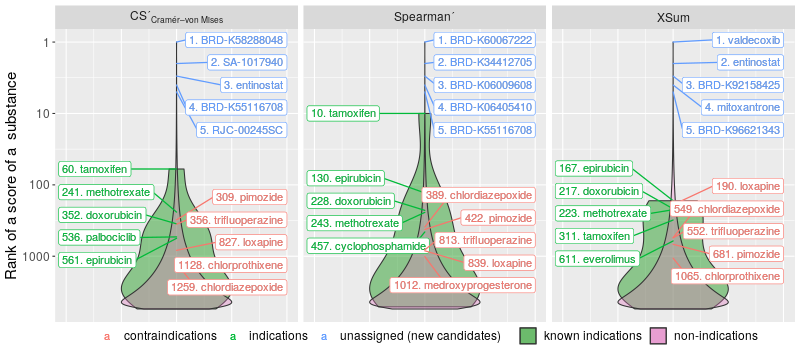

In [152]:
%%R -w 800 -h 350 -u px
top_ss = top_mcf7[top_mcf7$kind == 'single sample',]

a = (
    khinkali_plot(mcf7_scores[mcf7_scores$kind == 'single sample',], ncol=3)
    + label_with_shadow(top_ss, 'indications', -1)
    + label_with_shadow(top_ss, 'unassigned (new candidates)', 1)
    + label_with_shadow(top_ss, 'contraindications', 1)
    + khinkali_fill_colors()
    + guides(color=guide_legend(title=''))
    + xlim(0, 2)
    + theme(legend.margin=margin(t=-.9, unit='cm'))
)
#ggsave(file="BRCA_MCF7_ss_top_among_all.png", plot=g, width=8*1.4, height=3.5*1.4)
a

This goes as a supplementary figure maybe (or maybe not):

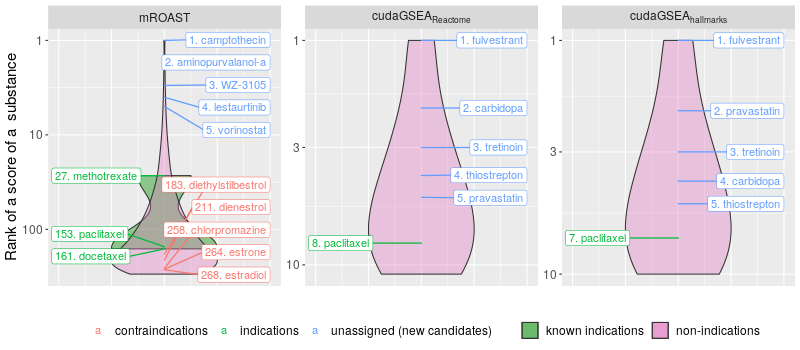

In [153]:
%%R -w 800 -h 350 -u px
top_ss = top_mcf7[top_mcf7$kind == 'multi sample',]

b = (
    khinkali_plot(mcf7_scores[mcf7_scores$kind == 'multi sample',], ncol=3,  scales='free_y')
    + rank_labels(top_ss, 'indications', -1)
    + rank_labels(top_ss, 'unassigned (new candidates)', 1)
    + rank_labels(top_ss, 'contraindications', 1)
    + khinkali_fill_colors()
    + guides(color=guide_legend(title=''))
    + xlim(0, 2)
)
#ggsave(file="BRCA_MCF7_ms_top_among_all.png", plot=g, width=5.5*1.4, height=5.5*1.4)
b

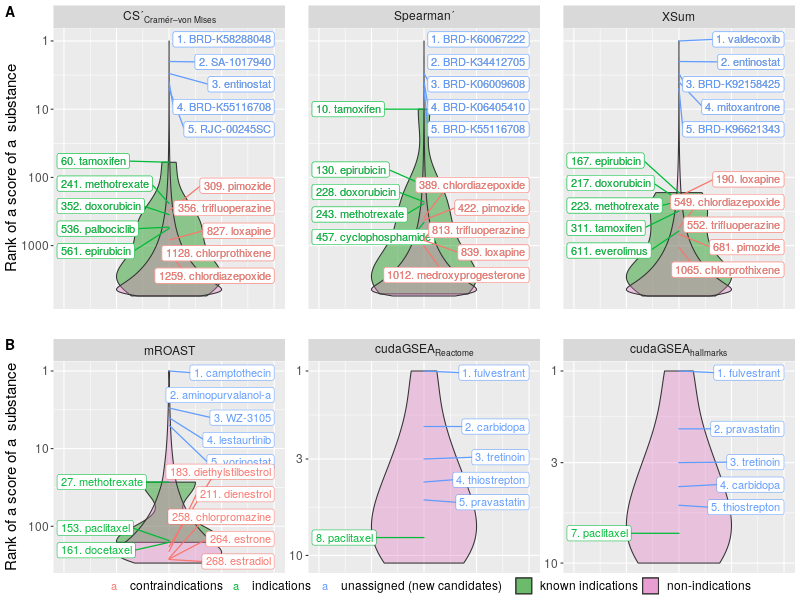

In [915]:
%%R -w 800 -h 600
g = cowplot::plot_grid(
    a + theme(legend.position="none"),
    b + theme(legend.margin=margin(t=-.9, unit='cm')),
    labels=c('A', 'B'), nrow=2, align = "v",
    rel_heights = c(5, 4)
)
ggsave(file="BRCA_MCF7_top_among_all.png", plot=g, width=9*1.3, height=7*1.3, dpi=150)
g

In [175]:
top_mcf7

,func,group,kind,pert_iname,raw_score,score,is_indication,known_indication,rank,label
20,CS'_{Cramér–von Mises},unassigned,single sample,BRD-K58288048,3.108168,1.000000,False,non-indications,1.0,1. BRD-K58288048
21,CS'_{Cramér–von Mises},unassigned,single sample,SA-1017940,2.932804,0.944143,False,non-indications,2.0,2. SA-1017940
22,CS'_{Cramér–von Mises},unassigned,single sample,entinostat,2.910685,0.937098,False,non-indications,3.0,3. entinostat
23,CS'_{Cramér–von Mises},unassigned,single sample,BRD-K55116708,2.841697,0.915124,False,non-indications,4.0,4. BRD-K55116708
24,CS'_{Cramér–von Mises},unassigned,single sample,RJC-00245SC,2.801727,0.902393,False,non-indications,5.0,5. RJC-00245SC
...,...,...,...,...,...,...,...,...,...,...
46,cudaGSEA_{hallmarks},unassigned,multi sample,pravastatin,0.795862,0.727915,False,non-indications,2.0,2. pravastatin
47,cudaGSEA_{hallmarks},unassigned,multi sample,tretinoin,0.752099,0.521251,False,non-indications,3.0,3. tretinoin
48,cudaGSEA_{hallmarks},unassigned,multi sample,carbidopa,0.744075,0.483362,False,non-indications,4.0,4. carbidopa
49,cudaGSEA_{hallmarks},unassigned,multi sample,thiostrepton,0.743417,0.480253,False,non-indications,5.0,5. thiostrepton


In [213]:
def top_ranking_table(top):
    top_data = []
    for pert_iname in top.pert_iname.unique():
        data = top[top.pert_iname == pert_iname]
        if (data.group == 'unassigned').all():
            for 
            top_data.append({
                'Name': pert_iname,
                'Nominated by': ','.join([f'{f}:' for f in data.func]),
                'Rank': ','.join(map(lambda x: str(int(x)), data['rank'])),
                'Mean rank': mean(data['rank']),
                'Paired evidence': len(data) > 1,
                'Manual evaluation': '' 
            })

    df = (
        DataFrame(top_data)
        .sort_values(['Paired evidence', 'Mean rank'], ascending=[False, True])
        .set_index('Name')
        [['Nominated by', 'Rank', 'Paired evidence', 'Manual evaluation']]
    )
    return df

In [340]:
dcm.pert_info.set_index('pert_iname').loc['BRD-K92202821']

pert_id                                                 BRD-K92202821
pert_type                                                      trt_cp
is_touchstone                                                       0
inchi_key_prefix                                       SLNSQTDVEFYGGW
inchi_key                                 SLNSQTDVEFYGGW-UHFFFAOYSA-N
canonical_smiles    COc1ccc(cc1COc1ccc(NC(C)=O)cc1)-c1nc2ccccc2c(=...
pubchem_cid                                                  17757314
Name: BRD-K92202821, dtype: object

In [214]:
df = top_ranking_table(top_mcf7)
df.to_clipboard()
show_table(df)

,Nominated by,Rank,Paired evidence,Manual evaluation
Name,,,,
fulvestrant,"cudaGSEA_{Reactome}:,cudaGSEA_{hallmarks}:","1,1",True,
entinostat,"CS'_{Cramér–von Mises}:,XSum:","3,2",True,
carbidopa,"cudaGSEA_{Reactome}:,cudaGSEA_{hallmarks}:","2,4",True,
tretinoin,"cudaGSEA_{Reactome}:,cudaGSEA_{hallmarks}:","3,3",True,
pravastatin,"cudaGSEA_{Reactome}:,cudaGSEA_{hallmarks}:","5,2",True,
BRD-K55116708,"CS'_{Cramér–von Mises}:,Spearman':","4,5",True,
thiostrepton,"cudaGSEA_{Reactome}:,cudaGSEA_{hallmarks}:","4,5",True,
BRD-K58288048,CS'_{Cramér–von Mises}:,1,False,
BRD-K60067222,Spearman':,1,False,


In [ ]:
def func_top_ranking_table(top):
    top_data = []
    for pert_iname in top.pert_iname.unique():
        data = top[top.pert_iname == pert_iname]
        if (data.group == 'unassigned').all():
            top_data.append({
                'Name': pert_iname,
                'Nominated by': ','.join([f'{f}:' for f in data.func]),
                'Rank': ','.join(map(lambda x: str(int(x)), data['rank'])),
                'Mean rank': mean(data['rank']),
                'Paired evidence': len(data) > 1,
                'Manual evaluation': '' 
            })

    df = (
        DataFrame(top_data)
        .sort_values(['Paired evidence', 'Mean rank'], ascending=[False, True])
        .set_index('Name')
        [['Nominated by', 'Rank', 'Paired evidence', 'Manual evaluation']]
    )
    return df
df = func_top_ranking_table(top_mcf7)

In [ ]:
%%R -w 800 -h 800 -u px -i ci_annotations -i carcinogenic_indications

levels(carcinogenic_indications$func) = latex_levels(carcinogenic_indications, 'func')
levels(ci_annotations$func) = latex_levels(ci_annotations, 'func')


g = (
    ggplot(carcinogenic_indications, aes(x=0.5, y=rank))
    + facet_grid('cohort ~ func', scales='free', space='free_y', labeller=label_parsed)

    + geom_rect(
        aes(
            xmin=-Inf, xmax=0.5,
            ymin=ifelse(rank==1, 0.68, rank-0.5),
            ymax=rank+0.5,
            color=group,
            fill=group#, width=width
            #size=log(rank+1,2)/100000
        ),
        alpha=0.5
    )
    + theme(
        legend.position='bottom',
        legend.box='horizontal',
        text=element_text(size=15),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        #panel.background = element_blank(),
        panel.grid.major=element_blank(),
        panel.grid.minor=element_blank()
    )
    + xlab('')
    + ylab(paste('Rank of a substance'))
    + scale_y_continuous(
        trans=reverselog_trans(2),
        expand=c(0,0,0,0.25)
    )
    #+ scale_fill_discrete(direction=1) 
    + geom_text(aes(
        label=pert_iname, size=1/rank,
        vjust=0.25, hjust=0,
        x=5
    ), show.legend=F)
    + scale_fill_manual(
        values=c(
            'carcinogenic indications'='#FF7F0E',
            'non-carcinogenic indications'='#499894'
        ),
        name=''
    )
    + scale_colour_manual(
                values=c(
            'carcinogenic indications'='#FF7F0E',
            'non-carcinogenic indications'='#499894'
        ),
        guide='none'
    )
    + guides(
        color=element_blank()
    )
    + geom_text(
        data=ci_annotations, aes(y=0.55, label=label),
        show.legend=F,
        hjust=0.5,
        x=25
    )
    + xlim(0, 50)
    + theme(
        #legend.position='bottom',
        #legend.box='horizontal',
        legend.margin=margin(t=-.8, unit='cm')
    )
)
ggsave(file="carcinogenic_indications.png", plot=g, width=8.5*1.3, height=9*1.3)
g

### Results combined from across all concentrations and cell lines

In [38]:
mss_scores = extract_scores_from_result(
    results_multi_sample_selected['meta:Scores'],
    scores_as_series=False, are_grouped_by_cell=False
)

Normlize single samples by cell:

In [50]:
cell_normalized_sss_scores = normalize_scores(sss_scores, rescale=False, by_cell=True)
cell_normalized_sss_scores = cell_normalized_sss_scores.drop('raw_score', axis=1)

In [52]:
%store sss_scores

Stored 'sss_scores' (DataFrame)


In [51]:
%store mss_scores
%store cell_normalized_sss_scores

Stored 'mss_scores' (DataFrame)
Stored 'cell_normalized_sss_scores' (DataFrame)


In [5]:
%store -r mss_scores
%store -r cell_normalized_sss_scores

Merge with multi-sample:

In [249]:
sel_scores.query('group == "contraindications" and func == "Spearman\'"').sort_values('rank')

,func,group,kind,pert_iname,score,...,rank,percentile,negative_validation,positive_validation,validation_group
5397,Spearman',contraindications,single sample,fluoxymesterone,0.288917,...,270.0,0.049880,False,True,positive
5330,Spearman',contraindications,single sample,promazine,0.247649,...,346.0,0.063920,False,False,contraindications
5327,Spearman',contraindications,single sample,triflupromazine,0.116800,...,709.0,0.130981,False,False,contraindications
5332,Spearman',contraindications,single sample,thiothixene,0.108033,...,748.0,0.138186,False,False,contraindications
5331,Spearman',contraindications,single sample,alimemazine,0.049494,...,1017.0,0.187881,False,False,contraindications
...,...,...,...,...,...,...,...,...,...,...,...
5359,Spearman',contraindications,single sample,oxymetholone,-0.355938,...,4522.0,0.835396,False,False,contraindications
5342,Spearman',contraindications,single sample,phylloquinone,-0.358899,...,4539.0,0.838537,False,False,contraindications
5339,Spearman',contraindications,single sample,norgestimate,-0.378487,...,4669.0,0.862553,False,False,contraindications
5356,Spearman',contraindications,single sample,olanzapine,-0.390315,...,4734.0,0.874561,False,False,contraindications


In [6]:
sel_scores = concat([
    cell_normalized_sss_scores.assign(kind='single sample'),
    mss_scores.assign(kind='multi sample')
]).drop('Index', axis=1).reset_index(drop=True)

sel_scores = sel_scores.drop('cell_id', axis=1)

Aggregate across different doses (and cells for single-sample) and mean-average:

In [7]:
sel_scores['score'] = sel_scores.groupby(['func', 'pert_iname'])['score'].transform('mean')
# cells were dropped beforehand
sel_scores = sel_scores[sel_scores.columns.difference(['pert_idose'])].drop_duplicates()

Rescale and rebuild:

In [8]:
from Plotting import nice_names_all

Importing Jupyter notebook from Plotting.ipynb
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
sel_scores = reload_and_process(sel_scores, nice_names_all, 'BRCA_results_selected_combined.csv')

In [19]:
sel_scores.head()

,func,group,kind,pert_iname,score,raw_score,is_indication,known_indication,rank
0,Spearman',indications,single sample,palbociclib,0.418827,1.698976,True,known indications,124.0
1,Spearman',indications,single sample,epirubicin,0.412712,1.681814,True,known indications,132.0
2,Spearman',indications,single sample,everolimus,0.412259,1.680542,True,known indications,134.0
3,Spearman',indications,single sample,cyclophosphamide,-0.100189,0.242115,True,known indications,2161.0
4,Spearman',indications,single sample,doxorubicin,0.439579,1.757226,True,known indications,98.0


In [14]:
%store -r sel_scores

#### Khinkali rank plot

In [18]:
top_selected = concat([
    n_best_in_group(sel_scores, group).assign(group=group)
    for group in sel_scores.group.unique()
])

In [24]:
top_selected['label'] = top_selected.apply(
    lambda x: f'{int(x["rank"])}. {x["pert_iname"]}',
    axis=1
)
top_selected = top_selected.reset_index()

In [27]:
%store top_selected

Stored 'top_selected' (DataFrame)


In [25]:
top_selected.head()

,func,group,kind,pert_iname,score,...,percentile,negative_validation,positive_validation,validation_group,label
0,CS'_{Cramér–von Mises},indications,single sample,everolimus,0.556805,...,0.011084,False,False,indications,60. everolimus
1,CS'_{Cramér–von Mises},indications,single sample,epirubicin,0.503829,...,0.019952,False,False,indications,108. epirubicin
2,CS'_{Cramér–von Mises},indications,single sample,doxorubicin,0.503290,...,0.020137,False,False,indications,109. doxorubicin
3,CS'_{Cramér–von Mises},indications,single sample,palbociclib,0.412510,...,0.033992,False,False,indications,184. palbociclib
4,CS'_{Cramér–von Mises},indications,single sample,tamoxifen,0.382643,...,0.040458,False,False,indications,219. tamoxifen


In [41]:
%%R
khinkali_labels_colors = scale_color_manual(guide='none', values=c(
    controls='#1F77B4',
    indications='#2CA02C',
    contraindications='#D62728',
    unassigned='#4E79A7'
))

/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))
/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))
/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

  warnings.warn(x, RRuntimeWarning)


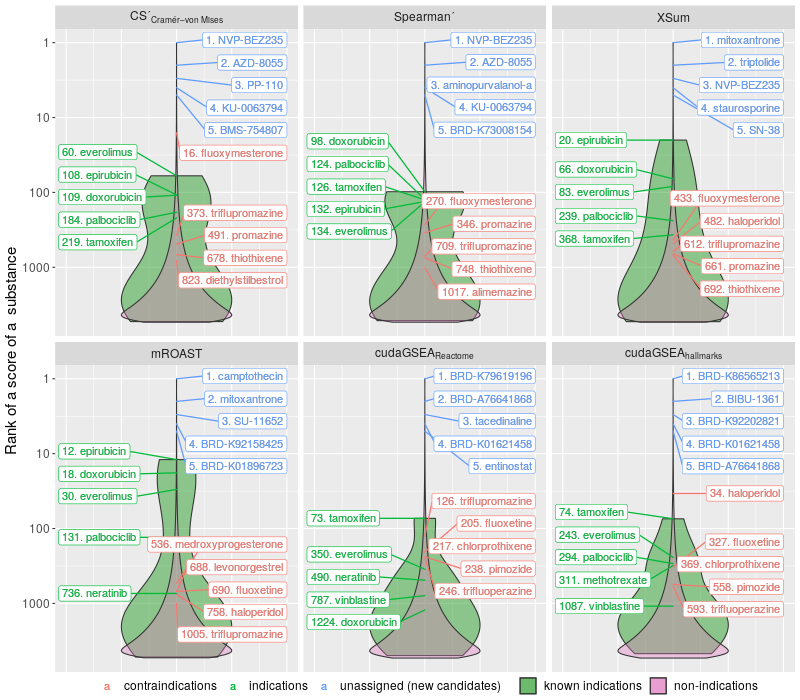

In [917]:
%%R -w 800 -h 700 -u px -i top_selected -i sel_scores
top_ss = top_selected
top_ss[top_ss == "unassigned"] = "unassigned (new candidates)"

levels(top_ss$func) = latex_levels(top_ss, 'func')
levels(sel_scores$func) = latex_levels(sel_scores, 'func')

g = (
    khinkali_plot(sel_scores, ncol=3)
    + label_with_shadow(top_ss, 'indications', -1)
    + label_with_shadow(top_ss, c('unassigned (new candidates)', 'contraindications'), 1)
    + khinkali_fill_colors()
    + guides(color=guide_legend(title=''))
    + xlim(0, 2)
    + theme(legend.margin=margin(t=-.9, unit='cm'))
)
ggsave(file="BRCA_both_top_among_all.png", plot=g, width=8*1.4, height=7*1.4, dpi=150)
g

/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))
/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


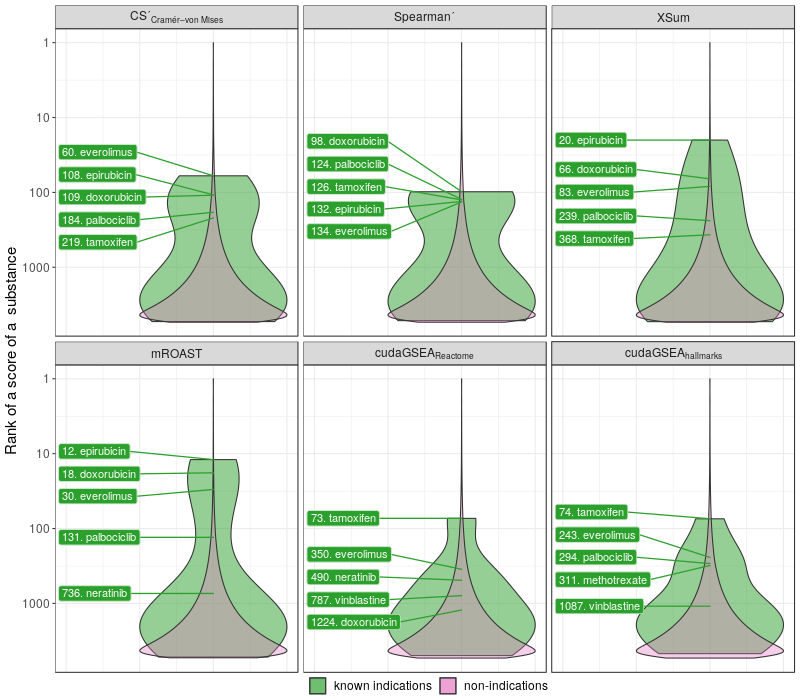

In [331]:
%%R -w 800 -h 700 -u px -i top_selected -i sel_scores
top_ss = top_selected
top_ss[top_ss == "unassigned"] = "unassigned (new candidates)"

levels(top_ss$func) = latex_levels(top_ss, 'func')
levels(sel_scores$func) = latex_levels(sel_scores, 'func')

g = (
    khinkali_plot(sel_scores, ncol=3)
    #+ label_with_shadow(top_ss, 'indications', -1)
    + rank_labels(top_ss, 'indications', -1, seed=0, fill='white', color='#2CA02C')
    + rank_labels(top_ss, 'indications', -1, seed=0, color='white', fill='#2CA02C', segment.size=0)
    + ggpubr::stat_compare_means(
        comparisons=list(c('indications', 'non-indications')),
        method="wilcox.test",
        method.args=list(alternative="greater")
    )

    #+ label_with_shadow(top_ss, c('unassigned (new candidates)', 'contraindications'), 1)
    + khinkali_fill_colors()
    + guides(color=guide_legend(title=''))
    + xlim(0, 1.5)
    + theme(legend.margin=margin(t=-.9, unit='cm'))
    #+ coord_cartesian(expand=c(3,3))
)
ggsave(file="BRCA_both_top_among_all_poster.png", plot=g, width=8*1, height=7*1, dpi=500)
g

In [217]:
df = top_ranking_table(top_selected)
df.to_clipboard()
show_table(df)

,Nominated by,Rank,Paired evidence,Manual evaluation
Name,,,,
mitoxantrone,"XSum:,mROAST:","1,2",True,
NVP-BEZ235,"CS'_{Cramér–von Mises}:,Spearman':,XSum:","1,1,3",True,
AZD-8055,"CS'_{Cramér–von Mises}:,Spearman':","2,2",True,
BRD-A76641868,"cudaGSEA_{Reactome}:,cudaGSEA_{hallmarks}:","2,5",True,
KU-0063794,"CS'_{Cramér–von Mises}:,Spearman':","4,4",True,
BRD-K01621458,"cudaGSEA_{Reactome}:,cudaGSEA_{hallmarks}:","4,4",True,
camptothecin,mROAST:,1,False,
BRD-K79619196,cudaGSEA_{Reactome}:,1,False,
BRD-K86565213,cudaGSEA_{hallmarks}:,1,False,


In [226]:
dcm.pert_info.set_index('pert_id').loc['BRD-K01621458']

pert_iname          BRD-K01621458
pert_type                  trt_cp
is_touchstone                   0
inchi_key_prefix             -666
inchi_key                    -666
canonical_smiles             -666
pubchem_cid                  -666
Name: BRD-K01621458, dtype: object

/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))
/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "is_indication". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


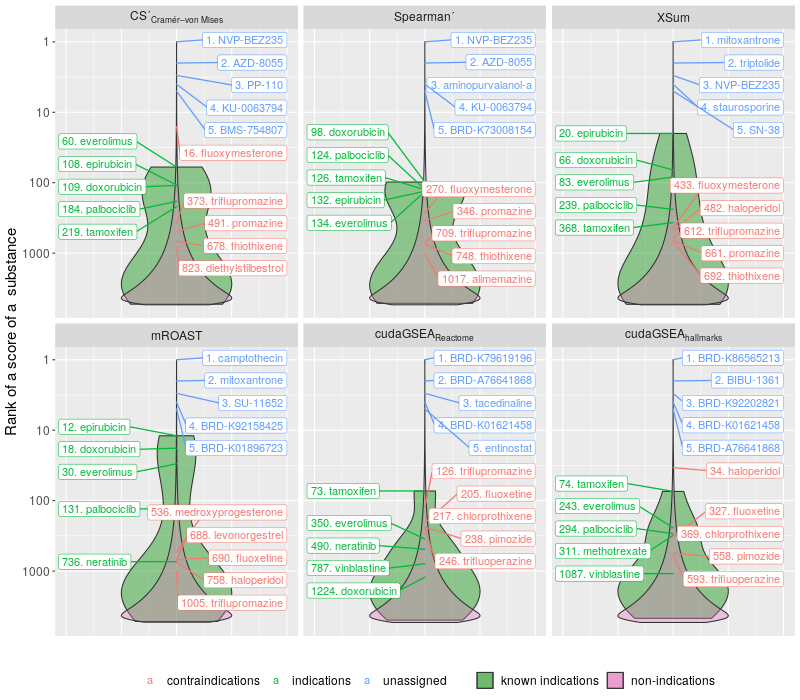

In [88]:
%%R -w 800 -h 700 -u px -i top_selected -i sel_scores
top_ss = top_selected

levels(top_ss$func) = latex_levels(top_ss, 'func')
levels(sel_scores$func) = latex_levels(sel_scores, 'func')

g = (
    khinkali_plot(sel_scores, ncol=3)
    + rank_labels(top_ss, 'indications', -1)
    + rank_labels(top_ss, c('unassigned', 'contraindications'), 1)
    + khinkali_fill_colors()
    + guides(color=guide_legend(title=''))
    + xlim(0, 2)
)
ggsave(file="BRCA_both_top_among_all_old.png", plot=g, width=8*1.4, height=8*1.4)
g

### Analysis

In [353]:
category = {
    0: 'No known associations with cancer',
    1: 'Associated with cancer',
    2: 'Known cancer drug'
}

Manually assigned categories:

In [354]:
category_assignments = {
    'fulvestrant': 2,
    'entinostat': 1,
    'BRD-K58288048': 0, # CID 44507326
    'SA-1017940': 1,    # CID 44507247
    'BRD-K60067222': 0, # CID 54613883
    'BRD-K34412705': 0, # CID 44487718
    'BRD-K06009608': 1, # CID 44506826
    'valdecoxib': 0,    # CID 119607
    'BRD-K92158425': 1, # CID 45100429  (based on patent which mentions potential for treatment of cancer)
    'camptothecin': 2,  
    'aminopurvalanol-a': 1, # CID: 6604931(inferred, mapping absent in pert_info file)
    'WZ-3105': 1, # CID: 42628507 (based on patents relating to cancer treatment)
    'carbidopa': 1,
    'tretinoin': 2,
    'pravastatin': 1,
    'BRD-K55116708': 1, # CID 44507138
    'RJC-00245SC': 0, # CID 2728620
    'BRD-K06405410': 0, # CID 24868581
    'mitoxantrone': 1,
    'BRD-K96621343': 0,
    'lestaurtinib': 2,
    'vorinostat': 2, # CID 5311, inferred
    'thiostrepton': 1, # CID 16129995
    # note: many mTOR relates stuff
    'NVP-BEZ235': 1,
    'AZD-8055': 1, # mtor
    'PP-110': 1, # mtor
    'KU-0063794': 1, # mtor
    'BMS-754807': 1, # tyrosine kinases
    'BRD-K73008154': 0,
    'triptolide': 1, # "Triptolide induces apoptosis of gastric cancer cells via inhibiting the overexpression of MDM2"- https://link.springer.com/article/10.1007%2Fs12032-014-0270-7
    'staurosporine': 1, # experimental drug
    'SN-38': 1, # based on patents
    'SU-11652': 1, #https://www.ncbi.nlm.nih.gov/pubmed/23920274
    'BRD-K01896723': 1, # based on patents
    'BRD-K79619196': 0,
    'BRD-A76641868': 0,
    'tacedinaline': 1,
    'BRD-K01621458': 0,
    'BRD-K86565213': 0,
    'BIBU-1361': 0, # 17756796
    'BRD-K92202821': 1# based on a patent
}

In [355]:
def rank_by_top_dicoveries(top):
    return top[top.group == 'unassigned'].groupby(['func']).apply(lambda x: (
        sum(
            category_assignments[s.pert_iname]
            for s in x.itertuples()
        )
    ))

In [356]:
%store -r top_mcf7

In [357]:
%store -r top_selected

In [358]:
df = DataFrame([
    {
        'pert_iname': discovery.pert_iname,
        'value': category_assignments[discovery.pert_iname],
        'cat': category[category_assignments[discovery.pert_iname]],
        'func': discovery.func,
        'cell': cell_lines,
        'neg_mean_rank': -discovery.rank,
        'rank': discovery.rank
    }
    for cell_lines, highest_scoring_dicoveries in [
        ['All eight cell lines', top_selected],
        ['MCF7 only', top_mcf7]
    ]
    for discovery in highest_scoring_dicoveries[
        highest_scoring_dicoveries.group == 'unassigned'
    ].itertuples()
])
# negative mean rank is used for sorting candidates in one of the plot variants
df.neg_mean_rank = (
    df
    .groupby(['cell', 'pert_iname'])
    .neg_mean_rank
    .transform('mean')
)

In [359]:
sum_all_cell_lines = rank_by_top_dicoveries(top_selected)
sum_mcf_7 = rank_by_top_dicoveries(top_mcf7)

In [360]:
df = df.sort_values(['value'])
df2 = concat([
    sum_all_cell_lines.to_frame('total').reset_index().assign(
        pert_iname='Total',
        cell='All eight cell lines'
    ),
    sum_mcf_7.to_frame('total').reset_index().assign(
        pert_iname='Total',
        cell='MCF7 only'
    )
])

df.func = pd.Categorical(df.func)
df.pert_iname = pd.Categorical(df.pert_iname, ordered=True)
df.cell = pd.Categorical(df.cell, ordered=True)
df.cat = pd.Categorical(df.cat, ordered=True, categories=category.values())

In [361]:
df.head()

,cat,cell,func,neg_mean_rank,pert_iname,rank,value
29,No known associations with cancer,All eight cell lines,cudaGSEA_{hallmarks},-3.5,BRD-A76641868,5.0,0
26,No known associations with cancer,All eight cell lines,cudaGSEA_{hallmarks},-2.0,BIBU-1361,2.0,0
25,No known associations with cancer,All eight cell lines,cudaGSEA_{hallmarks},-1.0,BRD-K86565213,1.0,0
23,No known associations with cancer,All eight cell lines,cudaGSEA_{Reactome},-4.0,BRD-K01621458,4.0,0
21,No known associations with cancer,All eight cell lines,cudaGSEA_{Reactome},-3.5,BRD-A76641868,2.0,0


In [362]:
%%R

plot_top_summary = function(df, df2, xlab_title='', ylab_title='') {    
    levels(df$func) = latex_levels(df, 'func')
    levels(df2$func) = latex_levels(df2, 'func')
    (
        ggplot(df, aes(y=func))
        + facet_grid(cell ~ .)
        + geom_tile(aes(fill=cat, x=pert_iname), show.legend=T)
        + geom_tile(data=df2, aes(x=-1), fill='white', width=2)
        + geom_label(data=df2, aes(label=total, x=0, color=total), x=-1)
        + scale_y_discrete(labels=function(l) parse(text=l))
        + theme_bw()
        + theme(
            legend.position='bottom',
            legend.box='horizontal',
            text=element_text(size=15),
            axis.text.x=element_text(angle=45, hjust=1, size=6),
            legend.margin=margin(t=-.8, unit='cm')
        )
        + ylab(ylab_title)
        + xlab(xlab_title)
        + scale_x_discrete(limits=unique(df$pert_iname))
        + geom_text(aes(label=value, x=pert_iname))
        + scale_color_continuous(high="#132B43", low="#56B1F7")
    )  
}

top_summary_category_guide = guide_legend(
    title='Category',
    direction='vertical',
    title.position="left"
)

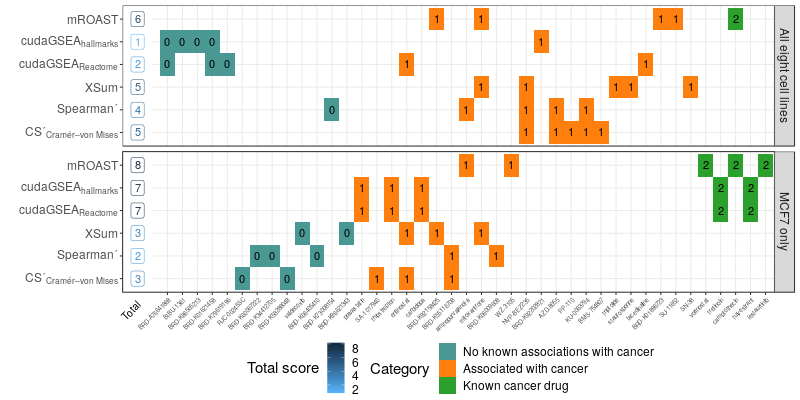

In [363]:
%%R -i df -w 800 -h 400 -i df2

summary_colors = c('#499894', '#FF7F0E', '#2CA02C')
summary_colorbar = function(vjust=1, direction='vertical', position='left') {
    guide_colorbar(
        title="Total score",
        title.position=position,
        direction=direction,
        barheight=3.5,
        order=1,
        label.vjust=vjust
    )
}

top_summary = (
    plot_top_summary(df, df2)
    + scale_fill_manual(
        values=summary_colors,
        guide=top_summary_category_guide
    )
    + guides(color=summary_colorbar())
)
gg = (
    cowplot::ggdraw(top_summary)
    + cowplot::draw_label(
        "Total", x=0.17, y=0.25,
        vjust=1, hjust=1, size=10, angle=45)
)
#ggsave(file="top_summary.png", plot=gg, width=8*1.3, height=4*1.3, dpi=150)
gg

Variant included on the first version of the poster:

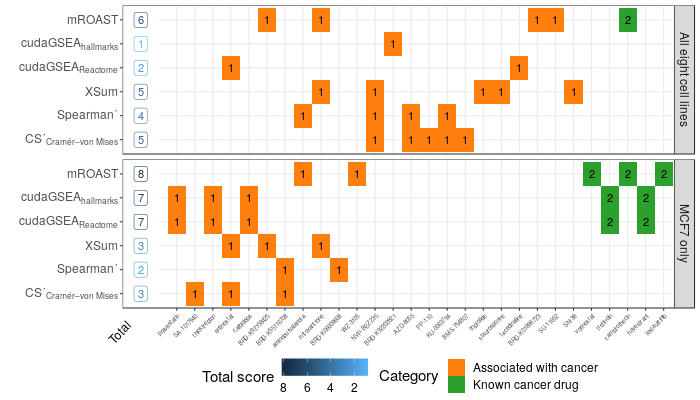

In [364]:
%%R -i df -w 700 -h 400 -i df2

df = df[df$cat != 'No known associations with cancer',]

top_summary_poster = (
    plot_top_summary(df, df2)
    + scale_fill_manual(
        values=summary_colors[2:3],
        guide=top_summary_category_guide
    )
    + guides(
        color=guide_colorbar(
            title="Total score",
            order=1,
            reverse=T
        )
    )
)

gg = (
    cowplot::ggdraw(top_summary_poster)
    + cowplot::draw_label(
        "Total", x=0.18, y=0.20,
        vjust=1, hjust=1, size=12, angle=45)
)

#ggsave(file="top_summary_poster.png", plot=gg, width=7*1.3, height=4*1.3, dpi=500)
gg

An alternative version without some disadvantages of those above:

In [365]:
df = df.sort_values('neg_mean_rank')
df.func = pd.Categorical(df.func)
df.pert_iname = df.pert_iname.cat.reorder_categories(list(df.pert_iname.unique()))
df.cell = pd.Categorical(df.cell, ordered=True)
df.cat = pd.Categorical(df.cat, ordered=True, categories=category.values())

In [405]:
%%R -i df -i df2

library(ggalluvial)

levels(df$func) = latex_levels(df, 'func')
levels(df2$func) = latex_levels(df2, 'func')

levels(df$cat)[levels(df$cat) == "No known associations with cancer"] <- "No known cancer association"

highest_scoring = function(df, df2, cell_line, orders, axis_position='left') {
    df = df[df$cell == cell_line,]
    df2 = df2[df2$cell == cell_line,]
    (
        ggplot(df, aes(y=factor(pert_iname, levels=rev(as.vector(
            trimws(orders[orders$cell==cell_line,'pert_iname'], 'r')
        ))), x=func))
        + facet_wrap(cell ~ ., scales='free', strip.position=ifelse(axis_position == 'left', 'right', 'left'))
        + geom_tile(aes(fill=cat, x=func), show.legend=T)
        + geom_tile(data=df2, aes(y=-1), fill='white', height=2)
        + geom_label(data=df2, aes(label=total, color=total), y=-1)
        + scale_x_discrete(position='top', labels=function(l) parse(text=l))
        + theme_bw()
        + theme(
            legend.position='right',
            legend.box='vertical',
            text=element_text(size=13),
            axis.text.x=element_text(angle=45, hjust=0, size=12),
            legend.margin=margin(t=.2, unit='cm')
        )
        + ylab('')
        + xlab('')
        + scale_y_discrete(position=axis_position)
        + geom_text(aes(label=rank, size='Substance rank'))
        + scale_fill_manual(
            values=summary_colors,
            guide=guide_legend(
                title='Category',
                direction='vertical',
                title.position="top"
            )
        )
        + scale_size_manual(
            values=c(3.5),
            guide=guide_legend(
                title='Ranking',
                override.aes=list(fill=summary_colors[2])
            )
        )
        + scale_color_continuous(high="#132B43", low="#56B1F7", breaks=c(2, 4, 6, 8))
        + guides(color=summary_colorbar(vjust=0.5, direction='vertical', position='top'))
    )
}

In [406]:
df_slim = df[df.columns.difference(['func', 'rank'])].drop_duplicates()
mcf7_only = df_slim[df_slim.cell == 'MCF7 only'].pert_iname

In [407]:
from collections import defaultdict
d = defaultdict(lambda: max([0, *d.values()])+1)
df_slim['subject'] = df_slim['pert_iname'].apply(lambda x: d[x])

In [408]:
# some tricks to get the ordering right
df_slim.pert_iname = df_slim.pert_iname.astype('str')
df_slim.loc[df_slim.cell=='MCF7 only', 'pert_iname'] = (
    df_slim.loc[df_slim.cell=='MCF7 only', 'pert_iname'].astype(str) + ' '
)
df_slim = df_slim.sort_values('neg_mean_rank', ascending=False)
df_slim['pert_iname'] = pd.Categorical(
    df_slim['pert_iname'],
    ordered=True,
    categories=list(
        df_slim.pert_iname.unique()
    )
)
df_slim.cell = df_slim.cell.cat.reorder_categories(['MCF7 only', 'All eight cell lines'], ordered=True)

In [409]:
%%R -i df_slim
labels_with_flow = function(text=T){
    g = (
        ggplot(df_slim, aes(x=cell, alluvium=subject, wieght=1, stratum=pert_iname))
        + theme_minimal()
        + ggalluvial::geom_flow(aes(fill=subject))
        + ylab('') + xlab('')
        + theme(
            legend.position='none',
            panel.grid.major=element_blank(),
            axis.ticks=element_blank(),
            axis.text=element_blank()
        )
        + scale_y_discrete(expand=c(0, 0))
        + scale_x_discrete(expand=c(0, 0))
    )
    if (text) {
        g = g + geom_text(stat="stratum", label.strata=T)
    }
    g
}

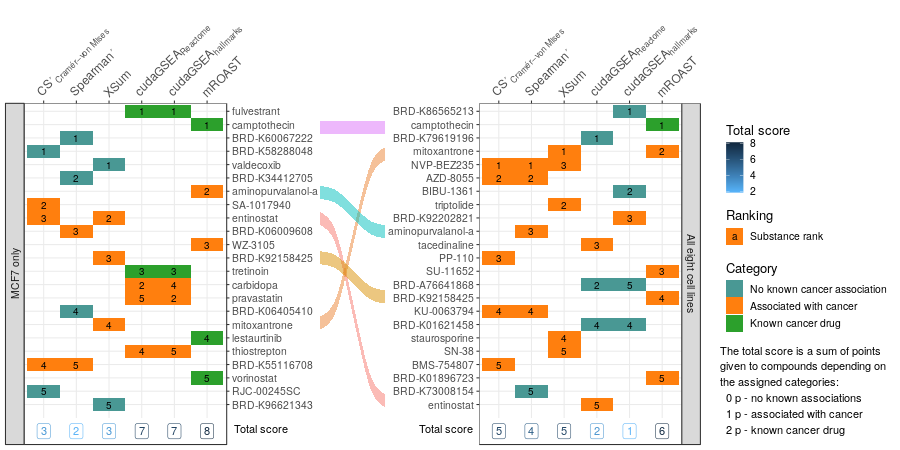

In [413]:
%%R -w 900 -h 450

a = highest_scoring(df, df2, 'MCF7 only', df_slim, axis_position='right')
b = highest_scoring(df, df2, 'All eight cell lines',  df_slim)

dm = theme_get()[["plot.margin"]][0]
m = -35

grid = cowplot::plot_grid(
    cowplot::plot_grid(
        a + theme(
            legend.position="none",
            plot.margin=unit(c(dm, -5.5*2, dm, dm), 'point')
        ),
        labels_with_flow(text=F) + theme(
            plot.margin=unit(c(108, m, 26, m - 13),"point")
        ),
        b + theme(
            legend.position="none",
            plot.margin=unit(c(dm, dm, dm, -5.5*2), 'point')
        ),
        ncol=3,
        rel_heights=c(1, 1.5, 1),
        rel_widths=c(1, 0.2, 1)
    ),
    cowplot::get_legend(a + theme(legend.position="right")),
    ncol=2,
    rel_widths=c(1, .275)
)
gg = (
    cowplot::ggdraw(grid)
    + cowplot::draw_label(
        "Total score", x=0.26, y=0.055,
        vjust=1, hjust=0, size=11, angle=0
    )
    + cowplot::draw_label(
        "Total score", x=0.465, y=0.055,
        vjust=1, hjust=0, size=11, angle=0
    )
    + cowplot::draw_label(
        "The total score is a sum of points\ngiven to compounds depending on\nthe assigned categories:\n  0 p - no known associations\n  1 p - associated with cancer\n  2 p - known cancer drug", x=0.8, y=0.23,
        vjust=1, hjust=0, size=11, angle=0, lineheight=1.2
    )
)
ggsave(file="top_summary_alternative.png", plot=gg, width=9*1.3, height=4.5*1.3, dpi=150)
ggsave(file="top_summary_alternative_poster.png", plot=gg, width=9*1.3, height=4.5*1.3, dpi=350)

gg

#### Very promising mROAST results

mROAST identified the most of known cancer drugs. Some of the mROAST results down the list are very promising. Here I show the top results for MCF7 cell line:

In [396]:
mcf7_mroast_candidates = mcf7_scores[mcf7_scores.func == 'mROAST'].sort_values('rank', ascending=True)
show_table(mcf7_mroast_candidates.head(20))

,func,group,kind,pert_iname,raw_score,score,is_indication,known_indication,rank
16437,mROAST,unassigned,multi sample,camptothecin,0.748964,1.000000,False,non-indications,1.0
16438,mROAST,unassigned,multi sample,aminopurvalanol-a,0.740928,0.986395,False,non-indications,2.0
16439,mROAST,unassigned,multi sample,WZ-3105,0.679414,0.882236,False,non-indications,3.0
16440,mROAST,unassigned,multi sample,lestaurtinib,0.673177,0.871676,False,non-indications,4.0
16441,mROAST,unassigned,multi sample,vorinostat,0.638979,0.813772,False,non-indications,5.0
16442,mROAST,unassigned,multi sample,ZG-10,0.634633,0.806413,False,non-indications,6.0
16443,mROAST,unassigned,multi sample,T-0156,0.616695,0.776039,False,non-indications,7.0
16444,mROAST,unassigned,multi sample,THZ-2-98-01,0.603912,0.754395,False,non-indications,8.0
16445,mROAST,unassigned,multi sample,daunorubicin,0.587210,0.726114,False,non-indications,9.0
16446,mROAST,unassigned,multi sample,TG-101348,0.573341,0.702630,False,non-indications,10.0


In [393]:
mcf7_mroast_candidates.to_csv('mcf7_mroast_candidates.csv')

#### Further analyses:

- systematic consensus ranking

## RepodDB

In [7]:
%store -r sel_scores

In [8]:
repodb = read_csv('../../data/repodb/full.csv')
repodb.drug_name = repodb.drug_name.str.lower()
repodb

,drug_name,drug_id,ind_name,ind_id,NCT,status,phase,DetailedStatus
0,lepirudin,DB00001,Heparin-induced thrombocytopenia with thrombosis,C0272275,NaN,Approved,NaN,NaN
1,cetuximab,DB00002,Squamous cell carcinoma of mouth,C0585362,NaN,Approved,NaN,NaN
2,cetuximab,DB00002,Squamous cell carcinoma of nose,C3163899,NaN,Approved,NaN,NaN
3,cetuximab,DB00002,Squamous cell carcinoma of pharynx,C1319317,NaN,Approved,NaN,NaN
4,cetuximab,DB00002,Laryngeal Squamous Cell Carcinoma,C0280324,NaN,Approved,NaN,NaN
...,...,...,...,...,...,...,...,...
10557,temozolomide,DB00853,CNS disorder,C0007682,NCT02661113,Withdrawn,Phase 2,Sponsor withdrew support; Study did not progre...
10558,dasatinib,DB01254,CNS disorder,C0007682,NCT02661113,Withdrawn,Phase 2,Sponsor withdrew support; Study did not progre...
10559,dacarbazine,DB00851,Brain Diseases,C0006111,NCT02661113,Withdrawn,Phase 2,Sponsor withdrew support; Study did not progre...
10560,temozolomide,DB00853,Brain Diseases,C0006111,NCT02661113,Withdrawn,Phase 2,Sponsor withdrew support; Study did not progre...


Drugs-disease matches in RepoDB are given one of four statuses:

In [65]:
set(repodb.status)

{'Approved', 'Suspended', 'Terminated', 'Withdrawn'}

#### Disease terms and drugs for breast cancer

In [44]:
matching_breast_keyword = repodb[repodb.ind_name.str.contains('breast')]

All of the diseases matched using breast keyword also include cancer/carcinoma/malignant neoplasm keyword:

In [44]:
matching_breast_keyword.ind_name.unique()

array(['Hormone receptor positive malignant neoplasm of breast',
       'HER2-positive carcinoma of breast',
       'Secondary malignant neoplasm of female breast',
       'Carcinoma breast stage IV',
       'Malignant epithelial neoplasm of female breast',
       'Human epidermal growth factor 2 negative carcinoma of breast',
       'Locally advanced breast cancer', 'Advanced breast cancer',
       'HER-2 positive breast cancer',
       'Oestrogen receptor positive breast cancer'], dtype=object)

Breast cancer-related subset has no suspended trials, which simplifies interpretation:

In [66]:
set(matching_breast_keyword.status)

{'Approved', 'Terminated', 'Withdrawn'}

In [72]:
breast_approved = matching_breast_keyword.query("status == 'Approved'")
# indications do not have data in some columns
breast_approved = breast_approved.dropna(how='all', axis='columns')

In [73]:
breast_failed = matching_breast_keyword.query("status != 'Approved'")

In [74]:
breast_approved

,drug_name,drug_id,ind_name,ind_id,status
22,goserelin,DB00014,Hormone receptor positive malignant neoplasm o...,C1562029,Approved
94,trastuzumab,DB00072,HER2-positive carcinoma of breast,C1960398,Approved
95,trastuzumab,DB00072,Secondary malignant neoplasm of female breast,C0346993,Approved
926,megestrol acetate,DB00351,Hormone receptor positive malignant neoplasm o...,C1562029,Approved
961,aminoglutethimide,DB00357,Secondary malignant neoplasm of female breast,C0346993,Approved
...,...,...,...,...,...
5977,pertuzumab,DB06366,HER2-positive carcinoma of breast,C1960398,Approved
6054,methyltestosterone,DB06710,Hormone receptor positive malignant neoplasm o...,C1562029,Approved
6207,eribulin,DB08871,Carcinoma breast stage IV,C0278488,Approved
6252,formestane,DB08905,Malignant epithelial neoplasm of female breast,C3163805,Approved


#### Previously analyzed drugs and substances

All substances with signature in LINCS:

In [75]:
all_substances = set(sel_scores.pert_iname)

Drugs analyzed for BRCA using DrugCentral:

In [76]:
train = set(sel_scores[sel_scores.is_indication==True].pert_iname)
train

{'cyclophosphamide',
 'docetaxel',
 'doxorubicin',
 'epirubicin',
 'everolimus',
 'formestane',
 'lapatinib',
 'methotrexate',
 'neratinib',
 'paclitaxel',
 'palbociclib',
 'tamoxifen',
 'thiotepa',
 'vinblastine'}

### Validation

In [79]:
validation_set = (set(breast_approved.drug_name) - train) & all_substances

In [80]:
validation_set

{'aminoglutethimide',
 'anastrozole',
 'capecitabine',
 'estradiol',
 'fluoxymesterone',
 'gemcitabine',
 'goserelin',
 'testosterone',
 'toremifene'}

In [81]:
scores_of_validation_set = sel_scores[sel_scores.pert_iname.isin(validation_set)]
scores_of_validation_set

,func,group,kind,pert_iname,score,...,rank,percentile,negative_validation,positive_validation,validation_group
943,Spearman',unassigned,single sample,aminoglutethimide,-0.323365,...,4299.0,0.794199,False,True,positive
1007,Spearman',unassigned,single sample,capecitabine,-0.241540,...,3547.0,0.655274,False,True,positive
2537,Spearman',unassigned,single sample,toremifene,-0.056325,...,1764.0,0.325882,False,True,positive
2730,Spearman',unassigned,single sample,anastrozole,-0.274023,...,3875.0,0.715869,True,True,positive
3575,Spearman',unassigned,single sample,goserelin,-0.292417,...,4046.0,0.747460,True,True,positive
...,...,...,...,...,...,...,...,...,...,...,...
31129,cudaGSEA_{Reactome},unassigned,multi sample,capecitabine,-0.208783,...,4227.0,0.787297,False,True,positive
31674,cudaGSEA_{Reactome},unassigned,multi sample,goserelin,-0.483161,...,4774.0,0.889179,True,True,positive
31795,cudaGSEA_{Reactome},unassigned,multi sample,aminoglutethimide,-0.543029,...,4895.0,0.911715,False,True,positive
32299,cudaGSEA_{Reactome},contraindications,multi sample,testosterone,-0.031570,...,3788.0,0.705532,False,True,positive


In [82]:
neg_validation_set = (set(breast_failed.drug_name) - train) & all_substances

In [32]:
sel_scores['positive_validation'] = sel_scores.pert_iname.isin(validation_set)

In [33]:
sel_scores['negative_validation'] = sel_scores.pert_iname.isin(neg_validation_set)

1. What is the overlap between repodb, lincs substances, and drugcentral?
2. "Some errors are inherent - patrz the entrometriosis thing"
3. first used smaller then larger db for validation

In [34]:
%store -r validation_perturbations

In [35]:
validation_scores = copy(sel_scores)

In [36]:
validation_scores['validation_group'] = 'unassigned'
validation_scores.loc[validation_scores.group=='contraindications', 'validation_group'] = 'contraindications'
validation_scores.loc[validation_scores.group=='indications', 'validation_group'] = 'indications'
validation_scores.loc[validation_scores.positive_validation, 'validation_group'] = 'indications'
validation_scores.loc[validation_scores.negative_validation, 'validation_group'] = 'failed indications'
validation_scores.is_indication = validation_scores.validation_group == 'indications' 
validation_scores['is_validation'] = validation_scores.positive_validation | validation_scores.negative_validation
validation_scores.group = validation_scores.validation_group 

In [37]:
validation_scores = validation_scores[validation_scores.validation_group != 'unassigned']
validation_scores.func = pd.Categorical(validation_scores.func)

In [93]:
assert not validation_scores.isnull().any().any()

In [41]:
%%R
source('../../helpers/plots/distribution_plot.R')

/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: notch went outside hinges. Try setting notch=FALSE.

  warnings.warn(x, RRuntimeWarning)


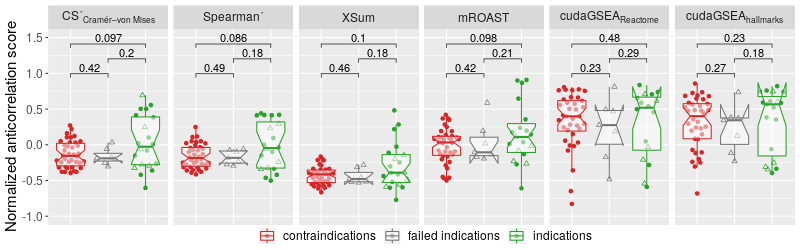

In [92]:
%%R -i validation_scores -w 800 -h 250 -u px
g <- (
    distribution_plot(
        validation_scores,
        to_compare=list(
            c('contraindications', 'failed indications'),
            c('indications', 'failed indications'),
            c('indications', 'contraindications')
        ),
        top_lim=1.5, ncol=6,
        mark='is_validation',
        mark_shape=24,
        mark_name=validation_scores$group
    )
)
#ggsave(file="repodb.png", plot=g, width=8*1.3, height=2.5*1.3, dpi=140)
g

In [909]:
compute_metrics_by_func(validation_scores, True, check_ranges=False)

,auc,auc0.01,auc0.1,func,log_loss
0,0.577803,0.628578,0.632663,Spearman',0.644562
1,0.562929,0.628578,0.627845,XSum,0.653234
2,0.568650,0.628578,0.627845,CS'_{Cramér–von Mises},0.651629
3,0.555024,0.588853,0.574415,mROAST,0.688021
4,0.521465,0.497487,0.560074,cudaGSEA_{hallmarks},0.937701
5,0.461988,0.523935,0.501385,cudaGSEA_{Reactome},1.028070


#### Side note: limitations of RepoDB

or rather of the underlying, unmerged disease ontologies

Some substances are shown as approved and failed for breast cancers:

In [83]:
shared = validation_set & neg_validation_set
', '.join(shared)

'goserelin, estradiol, anastrozole'

 While the authors discussed their procedure for handling such cases (i.e. taking the approved indications as more important than failed trials), it appears that some of the overlap can be attributed to a failure of this procedure to account for parallel disease ontologies, in which closely related entities are defined by slightly different terms (Oestrogen receptor positive breast cancer/Hormone receptor positive malignant neoplasm of breast):

In [91]:
breast_approved[breast_approved.drug_name.isin(shared)]

,drug_name,drug_id,ind_name,ind_id,status
22,goserelin,DB00014,Hormone receptor positive malignant neoplasm o...,C1562029,Approved
2905,estradiol,DB00783,Carcinoma breast stage IV,C0278488,Approved
4820,anastrozole,DB01217,Hormone receptor positive malignant neoplasm o...,C1562029,Approved


In [86]:
breast_failed[breast_failed.drug_name.isin(shared)]

,drug_name,drug_id,ind_name,ind_id,NCT,status,phase,DetailedStatus
7550,estradiol,DB00783,Malignant epithelial neoplasm of female breast,C3163805,NCT00183963,Terminated,Phase 2,Insufficient accrual
9254,goserelin,DB00014,Oestrogen receptor positive breast cancer,C2938924,NCT01368263,Terminated,Phase 2,Due to funding source and lack of accrual
9256,anastrozole,DB01217,Oestrogen receptor positive breast cancer,C2938924,NCT01368263,Terminated,Phase 2,Due to funding source and lack of accrual
9390,anastrozole,DB01217,Oestrogen receptor positive breast cancer,C2938924,NCT01394211,Terminated,Phase 2,Slow accrual


#### Disease terms and drugs for cancer of any tissue

In [52]:
matching_cancer_keywords = repodb[
    repodb.ind_name.str.contains('cancer')
    |
    repodb.ind_name.str.contains('carcinoma')
]

In [53]:
cancer_approved = matching_cancer_keywords.query("status == 'Approved'")

In [54]:
cancer_failed = matching_cancer_keywords.query("status != 'Approved'")

In [55]:
len(cancer_approved), len(cancer_failed)

(30, 626)

## Proposed further analyses:
- case study of the top three contraindications and candidates
- sensitivity, specificity AUC0.01, AUC0.1 to compare with previous studies
- cell lines and dosage analysis for single-sample functions (not possible for multi-sample ones)